# NEURAL NETWORKS: PROJECT 1

## Authors:
- Marina Gómez Rey (100472836)
- María Ángeles Magro Garrote (100472867)
- Ángela Durán Pinto (100472766)

## Abstract:
This code lab explores deep autoencoder implementations on MNIST and FMNIST databases. It compares 3-layer and 5-layer architectures, varying projected dimensions (15, 30, 50, 100), and explores different regularization techniques, including Lasso and Dropout regularization on the encoder's output. The best architecture is extended to denoising autoencoder using Gaussian noise with tunable variance. Performance is assessed using PSNR, and visual comparisons are made. The study aims to understand the impact of architecture, dimensionality reduction, and regularization on autoencoder performance in image tasks.



In [ ]:
# Packages
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import random
import torch.nn.functional as F
import math


# PART 1: Network Validation and Dimension Study

In this part, we aim to validate two network architectures: one with 3 layers in both encoder and decoder, and another with 5 layers. We'll analyze the influence of different projected dimensions (15, 30, 50, 100) on the performance of the autoencoder.

For each architecture and projected dimension, we will implement two distinct regularization techniques: Lasso and Dropout. Lasso regularization encourages sparsity in model parameters by penalizing large weight values, while Dropout randomly deactivates neurons during training to prevent overfitting. By evaluating the performance of autoencoders with Lasso and Dropout regularization across various dimensions, we seek to determine which technique better improves model generalization and prevents overfitting. This comparative analysis will provide valuable insights into selecting the most effective regularization approach for our autoencoder model.

---



## **Parameters** declaration

In [ ]:
# Device configuration: Determines whether to use CUDA (GPU) or CPU for computations.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters:
# - input_size: Number of pixels in each input image (28x28 = 784).
# - num_epochs: Number of iterations over the entire dataset during training.
# - batch_size: Number of samples processed in each iteration before updating the neural network weights.
# - learning_rate: Step size for the gradient descent optimization algorithm.
# - dropout_prob: Probability of dropout for regularization in the dropout autoencoder.
# - lasso_lambda: Strength of Lasso regularization for the Lasso autoencoder.

input_size = 784
num_epochs = 10
batch_size = 128
learning_rate = 0.001
dropout_prob = 0.2
lasso_lambda = 0.00001

# Train the denoising autoencoder for different noise variances.
noise_variances = [0.1, 0.25, 0.5, 0.75, 1]

# List of configurations:
# Each configuration is a tuple representing the number of layers in the encoder and decoder, respectively.
configurations = [
    (3, 15),
    (3, 30),
    (3, 50),
    (3, 100),
    (5, 15),
    (5, 30),
    (5, 50),
    (5, 100)
]

## **Autoencoders** creation

### Dropout

The Autoencoder_Dropout class constructs an autoencoder architecture with dropout regularization, accommodating encoder and decoder sections. It dynamically configures layers based on the specified number of layers, integrating linear transformations, ReLU activations, and dropout layers for regularization. The final encoder layer employs Tanh activation to confine output values within [-1, 1].

The dropout_prob parameter in the Autoencoder_Dropout class represents the probability of dropout for each neuron during training. This parameter allows for fine-tuning the dropout regularization strength. A dropout probability of 0.0 indicates no dropout, meaning all neurons remain active during training. Conversely, a value closer to 1.0 implies more aggressive dropout, where each neuron's output is set to zero with a higher likelihood during training. By adjusting the dropout_prob parameter, we can control the level of regularization applied to the autoencoder's layers, thereby influencing the model's capacity to generalize and prevent overfitting.

In [ ]:
class Autoencoder_Dropout(nn.Module):
    def __init__(self, num_layers, encoding_dim, dropout_prob=0.0):
        super(Autoencoder_Dropout, self).__init__()
        self.num_layers = num_layers
        self.encoding_dim = encoding_dim
        self.dropout_prob = dropout_prob

        # Encoder layers
        encoder_layers = []
        if self.num_layers == 3:
            encoder_layers.extend([
                nn.Linear(input_size, 512),
                nn.ReLU(True),
                nn.Dropout(p=self.dropout_prob),  # Dropout layer
                nn.Linear(512, 128),
                nn.ReLU(True),
                nn.Dropout(p=self.dropout_prob),   # Dropout layer
                nn.Linear(128, encoding_dim), # Hidden layer
                nn.Tanh()
            ])
        if self.num_layers == 5:
            encoder_layers.extend([
                nn.Linear(input_size, 512),
                nn.ReLU(True),
                nn.Dropout(p=self.dropout_prob),  # Dropout layer
                nn.Linear(512, 256),
                nn.ReLU(True),
                nn.Dropout(p=self.dropout_prob),  # Dropout layer
                nn.Linear(256, 128),
                nn.ReLU(True),
                nn.Dropout(p=self.dropout_prob),  # Dropout layer
                nn.Linear(128, 64),
                nn.ReLU(True),
                nn.Dropout(p=self.dropout_prob),    # Dropout layer
                nn.Linear(64, encoding_dim), # Hidden layer
                nn.Tanh()
            ])

        self.encoder = nn.Sequential(*encoder_layers)

        # Decoder layers
        decoder_layers = []

        if self.num_layers == 3:
            decoder_layers.extend([
                nn.Linear(encoding_dim, 128),
                nn.ReLU(True),
                nn.Dropout(p=self.dropout_prob),  # Dropout layer
                nn.Linear(128, 512),
                nn.ReLU(True),
                nn.Dropout(p=self.dropout_prob),  # Dropout layer
                nn.Linear(512, input_size), # Hidden layer
                nn.Tanh()
            ])
        if self.num_layers == 5:
            decoder_layers.extend([
                nn.Linear(encoding_dim, 64),
                nn.ReLU(True),
                nn.Dropout(p=self.dropout_prob),  # Dropout layer
                nn.Linear(64, 128),   # Adjusted output size
                nn.ReLU(True),
                nn.Dropout(p=self.dropout_prob),  # Dropout layer
                nn.Linear(128, 256),
                nn.ReLU(True),
                nn.Dropout(p=self.dropout_prob),  # Dropout layer
                nn.Linear(256, 512),
                nn.ReLU(True),
                nn.Dropout(p=self.dropout_prob),  # Dropout layer
                nn.Linear(512, input_size), # Hidden layer
                nn.Tanh()
            ])

        self.decoder = nn.Sequential(*decoder_layers)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

training_dropout function orchestrates the training process for the dropout autoencoder across various configurations. It iterates over each configuration, initializing a corresponding model and employing Adam optimizer with MSE loss. During training iterations, dropout is enabled, promoting model generalization by randomly zeroing a fraction of the neurons.

In [ ]:
def training_dropout(configurations, num_epochs, train_loader, test_dataset, dropout_prob, learning_rate):
    # Initialize lists to store losses for each configuration
    losses_dropout = {config: [] for config in configurations}

    best_loss = float('inf')
    best_model = None

    for num_layers, encoding_dim in configurations:
        # Initialize the model
        model = Autoencoder_Dropout(num_layers, encoding_dim, dropout_prob=dropout_prob).to(device)

        # Loss function and optimizer
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

        config_losses = []
        validation_losses = []

        # Training the autoencoder
        for epoch in range(num_epochs):
            epoch_loss = 0.0

            for data in train_loader:
                img, _ = data
                img = img.view(img.size(0), -1)
                img = img.to(device)

                # Forward pass with dropout
                model.train()  # Set the model to training mode
                output = model(img)
                loss = criterion(output, img)

                # Backward pass
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                epoch_loss += loss.item()

            # Compute average loss for the epoch
            epoch_loss /= len(train_loader)
            config_losses.append(epoch_loss)

             # Display input and output images using the current model
            # Get some random input images
            num_images = 20  # Number of random images to display
            indices = random.sample(range(len(test_dataset)), num_images)  # Randomly sample indices from the test dataset
            images = torch.stack([test_dataset[i][0] for i in indices]).to(device)  # Select random images from the dataset

            # Compute validation loss
            with torch.no_grad():
                model.eval()
                validation_loss = 0.0
                for data in test_dataset:
                    img, _ = data
                    img = img.view(img.size(0), -1)
                    img = img.to(device)
                    output = model(img)
                    loss = criterion(output, img)
                    validation_loss += loss.item()
                validation_loss /= len(test_dataset)
                reconstructed_images = model(images.view(images.size(0), -1)).cpu()
            validation_losses.append(validation_loss)

            # Print progress
            print('Configuration: num_layers={}, encoding_dim={}'.format(num_layers, encoding_dim))
            print('Epoch [{}/{}], Training Loss: {:.4f}, Validation Loss: {:.4f}'.format(epoch + 1, num_epochs,
                                                                                            epoch_loss,
                                                                                            validation_loss))

            # Save the best model based on validation loss
            if validation_loss < best_loss:
                best_loss = validation_loss
                best_model = model

        losses_dropout[(num_layers, encoding_dim)] = validation_losses

        # Reshape images for plotting
        images = images.view(-1, 28, 28)
        reconstructed_images = reconstructed_images.view(-1, 28, 28)

        # Plot input and output images
        plot_images(images, reconstructed_images, title="Input and Output Images")

    print("Best Validation Loss:", best_loss)

    return best_loss, best_model, losses_dropout


### Lasso

The Autoencoder_Lasso class defines an autoencoder architecture tailored for Lasso regularization, featuring encoder and decoder components. Conditional upon the specified number of layers (num_layers) and encoding dimension (encoding_dim), it configures the encoder layers to comprise linear transformations followed by ReLU activations, ensuring non-linearity, and culminates with a Tanh activation to constrain output values within the range [-1, 1]. The decoder follows the same train of thought.


In [ ]:
class Autoencoder_Lasso(nn.Module):
    def __init__(self, num_layers, encoding_dim):
        super(Autoencoder_Lasso, self).__init__()
        self.num_layers = num_layers
        self.encoding_dim = encoding_dim


        # Encoder layers
        encoder_layers = []
        if self.num_layers == 3:
            encoder_layers.extend([
                nn.Linear(input_size, 512),
                nn.ReLU(True),
                nn.Linear(512, 128),
                nn.ReLU(True),
                nn.Linear(128, encoding_dim),
                nn.Tanh()
            ])
        if self.num_layers == 5:
            encoder_layers.extend([
                nn.Linear(input_size, 512),
                nn.ReLU(True),
                nn.Linear(512, 256),
                nn.ReLU(True),
                nn.Linear(256, 128),
                nn.ReLU(True),
                nn.Linear(128, 64),                # Additional layer
                nn.ReLU(True),                      # Additional activation
                nn.Linear(64, encoding_dim),
                nn.Tanh()
            ])

        self.encoder = nn.Sequential(*encoder_layers)

        # Decoder layers
        decoder_layers = []

        if self.num_layers == 3:
            decoder_layers.extend([
                nn.Linear(encoding_dim, 128),
                nn.ReLU(True),
                nn.Linear(128, 512),
                nn.ReLU(True),
                nn.Linear(512, input_size),
                nn.Tanh()
            ])
        if self.num_layers == 5:
            decoder_layers.extend([
                nn.Linear(encoding_dim, 64),
                nn.ReLU(True),
                nn.Linear(64, 128),   # Adjusted output size
                nn.ReLU(True),
                nn.Linear(128, 256),
                nn.ReLU(True),
                nn.Linear(256, 512),
                nn.ReLU(True),
                nn.Linear(512, input_size),
                nn.Tanh()
            ])

        self.decoder = nn.Sequential(*decoder_layers)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In the training_lasso function, Lasso regularization is implemented by adding a penalty term to the loss function during training. Specifically, the L1 norm of the encoder's weights (parameters) is computed using torch.norm(model.encoder[-2].weight, p=1) within the loop over each batch of data. This L1 norm term is then multiplied by the lasso_lambda parameter, representing the strength of the Lasso regularization. The resulting regularization term is added to the original loss computed using mean squared error (MSE) to form the total loss for optimization.

In [ ]:
def training_lasso(configurations, num_epochs, train_loader, test_dataset, lasso_lambda, learning_rate):
    # Initialize lists to store losses for each configuration
    losses_lasso = {config: [] for config in configurations}

    best_loss = float('inf')
    best_model = None

    for num_layers, encoding_dim in configurations:
        # Initialize the model
        model = Autoencoder_Lasso(num_layers, encoding_dim).to(device)

        # Loss function and optimizer
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

        # Initialize a list to store losses for this configuration
        config_losses = []
        validation_losses = []

        # Training the autoencoder
        for epoch in range(num_epochs):
            epoch_loss = 0.0

            for data in train_loader:
                img, _ = data
                img = img.view(img.size(0), -1)
                img = img.to(device)

                # Forward pass with dropout
                model.train()  # Set the model to training mode
                output = model(img)
                loss = criterion(output, img)

                # Lasso regularization
                lasso_loss = lasso_lambda * torch.norm(model.encoder[-2].weight, p=1)  # L1 norm of the encoder's weights
                loss += lasso_loss

                # Backward pass
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                epoch_loss += loss.item()

            # Compute average loss for the epoch
            epoch_loss /= len(train_loader)
            config_losses.append(epoch_loss)

            # Display input and output images using the current model
            # Get some random input images
            num_images = 20  # Number of random images to display
            indices = random.sample(range(len(test_dataset)), num_images)  # Randomly sample indices from the test dataset
            images = torch.stack([test_dataset[i][0] for i in indices]).to(device)  # Select random images from the dataset

            # Compute validation loss
            with torch.no_grad():
                model.eval()
                validation_loss = 0.0
                for data in test_dataset:
                    img, _ = data
                    img = img.view(img.size(0), -1)
                    img = img.to(device)
                    output = model(img)
                    loss = criterion(output, img)
                    validation_loss += loss.item()
                validation_loss /= len(test_dataset)
                reconstructed_images = model(images.view(images.size(0), -1)).cpu()
            validation_losses.append(validation_loss)

            # Print progress
            print('Configuration: num_layers={}, encoding_dim={}'.format(num_layers, encoding_dim))
            print('Epoch [{}/{}], Training Loss: {:.4f}, Validation Loss: {:.4f}'.format(epoch + 1, num_epochs,
                                                                                            epoch_loss,
                                                                                            validation_loss))

            # Save the best model based on validation loss
            if validation_loss < best_loss:
                best_loss = validation_loss
                best_model = model

        losses_lasso[(num_layers, encoding_dim)] = validation_losses

        # Reshape images for plotting
        images = images.view(-1, 28, 28)
        reconstructed_images = reconstructed_images.view(-1, 28, 28)

        # Plot input and output images
        plot_images(images, reconstructed_images, title="Input and Output Images")

    print("Best Validation Loss:", best_loss)

    return best_loss, best_model, losses_lasso


## Graphs
* The **plot_images** function facilitates the visual comparison of input and output images generated by an autoencoder model.  This visualization aids in assessing the performance of the autoencoder by allowing direct inspection of how well the model is able to reconstruct input images.
* The **display_images** function is designed to display input and output images using the best model trained.
* The **plot_loss** function is responsible for plotting the loss curves during the training process of autoencoder models with Lasso regularization and dropout regularization.


In [ ]:
# Function to plot input and output images
def plot_images(input_images, output_images, title):
    num_images = len(input_images)
    fig, axes = plt.subplots(2, num_images, figsize=(12, 4))
    fig.suptitle(title, fontsize=16)

    for i in range(num_images):
        # Plot input images
        axes[0, i].imshow(input_images[i].squeeze().cpu(), cmap='gray')  # Move to CPU before plotting
        axes[0, i].set_title('Input')
        axes[0, i].axis('off')

        # Plot output images
        axes[1, i].imshow(output_images[i].squeeze().cpu(), cmap='gray')  # Move to CPU before plotting
        axes[1, i].set_title('Output')
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()


# Function to display input and output images using the best model
def display_images(best_model, loader, num_images=5):
    # Get some random input images
    images, _ = next(iter(loader))
    indices = random.sample(range(len(loader)), num_images)
    images = images[indices].to(device)

    # Pass images through the best model
    with torch.no_grad():
        best_model.eval()
        reconstructed_images = best_model(images.view(images.size(0), -1))

    # Reshape images for plotting
    images = images.view(-1, 28, 28)
    reconstructed_images = reconstructed_images.view(-1, 28, 28)

    # Plot input and output images
    plot_images(images, reconstructed_images, title="Input and Output Images")



In [ ]:
def plot_loss(num_epochs, losses_lasso, losses_dropout):

    colors = ['r', 'g', 'y', 'b']
    # Define colors for different dimensions

    dimensions = [15, 30, 50, 100]

    # Create a grid of 2x2 subplots
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))


    row = 0
    col = 0
    # Plot losses for Lasso regularization: 3 layers
    for i, dim in enumerate(dimensions):
        # row = i // 2
        # col = i % 2
        axs[row, col].plot(range(1, num_epochs + 1), losses_lasso[(3, dim)], color=colors[i], label=f'{dim} dim (Lasso)', marker='o', linestyle='-')
        axs[row, col].set_xlabel('Epochs')
        axs[row, col].set_ylabel('Loss')
        axs[row, col].set_title(f'Loss with Lasso Regularization for 3 layers')
        axs[row, col].legend()
        axs[row, col].grid(True)


    row = 0
    col = 1
    # Plot losses for Lasso regularization: 5 layers
    for i, dim in enumerate(dimensions):
        # row = i // 2
        # col = i % 2
        axs[row, col].plot(range(1, num_epochs + 1), losses_lasso[(5, dim)], color=colors[i], label=f'{dim} dim (Lasso)', marker='o', linestyle='-')
        axs[row, col].set_xlabel('Epochs')
        axs[row, col].set_ylabel('Loss')
        axs[row, col].set_title(f'Loss with Lasso Regularization for 5 layers')
        axs[row, col].legend()
        axs[row, col].grid(True)



    row = 1
    col = 0
    # Plot losses for Dropout regularization: 3 layers
    for i, dim in enumerate(dimensions):
        # row = i // 2
        # col = i % 2
        axs[row, col].plot(range(1, num_epochs + 1), losses_dropout[(3, dim)], color=colors[i], label=f'{dim} dim (Dropout)', marker='o', linestyle='-')
        axs[row, col].set_xlabel('Epochs')
        axs[row, col].set_ylabel('Loss')
        axs[row, col].set_title(f'Loss with Dropout Regularization for 3 layers')
        axs[row, col].legend()
        axs[row, col].grid(True)



    row = 1
    col = 1
    # Plot losses for Dropout regularization: 5 layers
    for i, dim in enumerate(dimensions):
        # row = i // 2
        # col = i % 2
        axs[row, col].plot(range(1, num_epochs + 1), losses_dropout[(5, dim)], color=colors[i], label=f'{dim} dim (Dropout)', marker='o', linestyle='-')
        axs[row, col].set_xlabel('Epochs')
        axs[row, col].set_ylabel('Loss')
        axs[row, col].set_title(f'Loss with Dropout Regularization for 5 layers')
        axs[row, col].legend()
        axs[row, col].grid(True)

    plt.tight_layout()
    plt.grid(True)
    plt.show()



# PART 2

In this section, we extend the analysis of the best-performing autoencoder architecture by implementing a denoising autoencoder. By introducing additive zero-mean Gaussian noise of tunable variance to the input data, we aim to assess the autoencoder's ability to reconstruct and denoise corrupted signals. We analyze the performance of the denoising autoencoder across different levels of noise variance, evaluating the reconstructed signals' fidelity compared to the original inputs. As a performance metric, we employ the Peak signal-to-noise ratio (PSNR), which quantifies the quality of the reconstructed signals. Additionally, we visualize the reconstructed and denoised signals alongside their corresponding input signals to provide qualitative insights into the denoising capabilities of the autoencoder. Through this analysis, we aim to gain a comprehensive understanding of the denoising autoencoder's effectiveness in mitigating noise and preserving signal integrity.

### Traning autoencoder

This function trains a denoising autoencoder with varying levels of Gaussian noise variance. It uses the best autoencoder architecture found earlier, optimizing parameters to reconstruct clean signals from noisy inputs. The Mean Squared Error (MSE) loss function and Lasso regularization are employed, while the Peak signal-to-noise ratio (PSNR) serves as a performance metric. Validation PSNR is also computed to assess generalization.

In [ ]:
# Function to calculate PSNR
def psnr(original, denoised, max_val=1.0):
    mse = F.mse_loss(original, denoised)
    psnr = 20 * torch.log10(max_val / torch.sqrt(mse))
    return psnr.item()

def training_denoising(learning_rate, num_epochs, best_model, noise_variances, train_loader, test_loader):

    # Initialize lists to store losses for each configuration
    psnr_dict = {variance: [] for variance in noise_variances}

    for noise_variance in noise_variances:
        print(f"Training with noise variance: {noise_variance}")

        psnr_list = []
        validation_psnr_list = []

        # Initialize the denoising autoencoder model
        denoising_model = Autoencoder_Lasso(best_model.num_layers, best_model.encoding_dim).to(device)

        # Loss function and optimizer
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(denoising_model.parameters(), lr=learning_rate, weight_decay=1e-5)

        # Train the denoising autoencoder
        denoising_model.train()
        for epoch in range(num_epochs):
            total_psnr = 0.0
            for data in train_loader:
                img, _ = data
                img = img.view(img.size(0), -1)
                img = img.to(device)

                # Add noise to the input images
                noisy_img = add_noise(img, noise_variance)

                # Forward pass
                output = denoising_model(noisy_img)
                loss = criterion(output, img)

                # Lasso regularization
                lasso_loss = lasso_lambda * torch.norm(denoising_model.encoder[-2].weight, p=1)  # L1 norm of the encoder's weights
                loss += lasso_loss

                # Backward pass
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # Calculate PSNR
                batch_psnr = psnr(img, output)
                total_psnr += batch_psnr

            # Average PSNR over all batches
            avg_psnr = total_psnr / len(train_loader)
            psnr_list.append(avg_psnr)

            # Compute validation PSNR
            total_psnr = 0.0
            denoising_model.eval()
            with torch.no_grad():
                for data in test_loader:
                    img, _ = data
                    img = img.view(img.size(0), -1)
                    img = img.to(device)
                    noisy_img = add_noise(img, noise_variance)
                    output = denoising_model(noisy_img)
                    batch_psnr = psnr(img, output)
                    total_psnr += batch_psnr
            validation_psnr = total_psnr / len(test_loader)
            validation_psnr_list.append(validation_psnr)

            # Print progress
            print('Epoch [{}/{}], Loss: {:.4f}, PSNR: {:.4f}, Validation PSNR: {:.4f}'.format(epoch + 1, num_epochs, loss.item(), avg_psnr, validation_psnr))

        psnr_dict[noise_variance] = validation_psnr_list

        # Display input, noised input, and output images using the denoising autoencoder
        display_images_with_noise(denoising_model, test_loader, noise_variance)

    return psnr_dict

### Image noise and plotting

 * The **add_noise** function introduces Gaussian noise with a specified variance to input images, aiding in the training of the denoising autoencoder.
 * The **plot_images_denoising** plots sets of input, noisy input, and output images to visualize the denoising performance of the autoencoder.
 * The **display_images_with_noise** function utilizes the trained denoising model to generate and display these images, highlighting the impact of noise variance on the reconstruction quality.
 * Finally, the **plot_denoising** function visualizes the distribution of PSNR values across epochs, providing insights into the denoising performance over the training process.

In [ ]:
# Function to add noise to input images
def add_noise(images, noise_variance):
    noise = torch.randn_like(images, device=images.device) * noise_variance
    noisy_images = images + noise
    return noisy_images

# Function to plot input, noised input, and output images
def plot_images_denoising(input_images, noisy_images, output_images, title):
    num_images = len(input_images)
    fig, axes = plt.subplots(3, num_images, figsize=(12, 6))
    fig.suptitle(title, fontsize=16)

    for i in range(num_images):
        # Plot input images
        axes[0, i].imshow(input_images[i].squeeze().cpu(), cmap='gray')  # Move to CPU before plotting
        axes[0, i].set_title('Input')
        axes[0, i].axis('off')

        # Plot noised input images
        axes[1, i].imshow(noisy_images[i].squeeze().cpu(), cmap='gray')  # Move to CPU before plotting
        axes[1, i].set_title('Noised Input')
        axes[1, i].axis('off')

        # Plot output images
        axes[2, i].imshow(output_images[i].squeeze().cpu(), cmap='gray')  # Move to CPU before plotting
        axes[2, i].set_title('Output')
        axes[2, i].axis('off')

    plt.tight_layout()
    plt.show()

# Function to display input, noised input, and output images using the denoising autoencoder
def display_images_with_noise(denoising_model, loader, noise_variance, num_images=5):
    device = next(denoising_model.parameters()).device  # Get the device of the model

    # Get some random input images
    data_iter = iter(loader)
    images, _ = next(data_iter)
    images = images[:num_images].to(device)  # Move images to GPU

    # Add noise to the input images
    noisy_images = add_noise(images, noise_variance)

    # Pass images through the denoising autoencoder
    with torch.no_grad():
        denoising_model.eval()
        reconstructed_images = denoising_model(noisy_images.view(noisy_images.size(0), -1)).cpu()

    # Reshape images for plotting
    images = images.view(-1, 28, 28)
    noisy_images = noisy_images.view(-1, 28, 28)
    reconstructed_images = reconstructed_images.view(-1, 28, 28)

    # Plot input, noised input, and output images
    plot_images_denoising(images, noisy_images, reconstructed_images, title=f"Input, Noised Input (variance={noise_variance}), and Output Images")

def plot_denoising(psnr_dict):

    # Plotting the data with lines connecting points
    for i, (key, values) in enumerate(psnr_dict.items()):
        plt.plot(range(1, len(values) + 1), values, marker='o', linestyle='-', label=str(key))

    plt.xlabel('Epoch')
    plt.ylabel('PSNR')
    plt.title('PSNR Distribution')
    plt.legend(title='Category')
    plt.grid(True)
    plt.show()


# MNIST

In this part, the MNIST dataset will be used.

In [ ]:

####  MNIST dataset  ####
train_dataset = torchvision.datasets.MNIST(root='./data',
                                           train=True,
                                           transform=transform,
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='./data',
                                          train=False,
                                          transform=transform)

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

# Define a transformation pipeline for image preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalize the image tensor with mean and standard deviation
])


100%|██████████| 9912422/9912422 [00:00<00:00, 86179779.96it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 42488843.85it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 148018992.71it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 22151777.64it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



### MNIST - DROPOUT

Configuration: num_layers=3, encoding_dim=15
Epoch [1/10], Training Loss: 0.2792, Validation Loss: 0.2704
Configuration: num_layers=3, encoding_dim=15
Epoch [2/10], Training Loss: 0.2703, Validation Loss: 0.2704
Configuration: num_layers=3, encoding_dim=15
Epoch [3/10], Training Loss: 0.2041, Validation Loss: 0.1257
Configuration: num_layers=3, encoding_dim=15
Epoch [4/10], Training Loss: 0.1322, Validation Loss: 0.1067
Configuration: num_layers=3, encoding_dim=15
Epoch [5/10], Training Loss: 0.1212, Validation Loss: 0.0959
Configuration: num_layers=3, encoding_dim=15
Epoch [6/10], Training Loss: 0.1146, Validation Loss: 0.0890
Configuration: num_layers=3, encoding_dim=15
Epoch [7/10], Training Loss: 0.1101, Validation Loss: 0.0855
Configuration: num_layers=3, encoding_dim=15
Epoch [8/10], Training Loss: 0.1070, Validation Loss: 0.0822
Configuration: num_layers=3, encoding_dim=15
Epoch [9/10], Training Loss: 0.1046, Validation Loss: 0.0794
Configuration: num_layers=3, encoding_dim=15
E

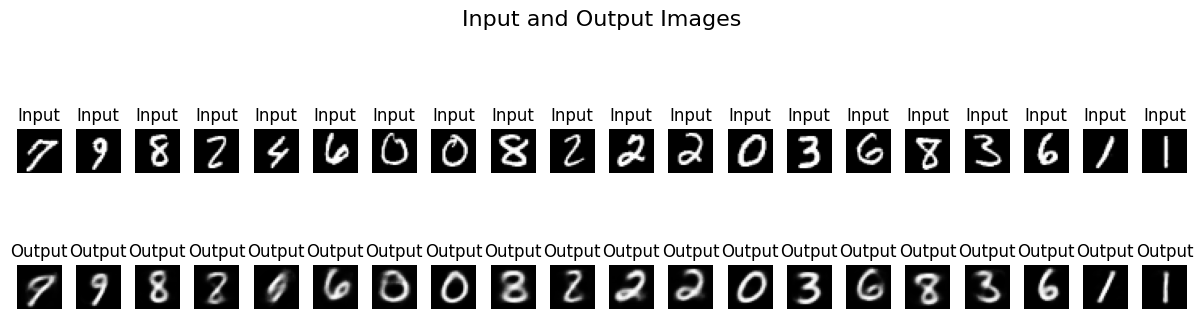

Configuration: num_layers=3, encoding_dim=30
Epoch [1/10], Training Loss: 0.2340, Validation Loss: 0.1392
Configuration: num_layers=3, encoding_dim=30
Epoch [2/10], Training Loss: 0.1334, Validation Loss: 0.0986
Configuration: num_layers=3, encoding_dim=30
Epoch [3/10], Training Loss: 0.1136, Validation Loss: 0.0853
Configuration: num_layers=3, encoding_dim=30
Epoch [4/10], Training Loss: 0.1063, Validation Loss: 0.0798
Configuration: num_layers=3, encoding_dim=30
Epoch [5/10], Training Loss: 0.1018, Validation Loss: 0.0748
Configuration: num_layers=3, encoding_dim=30
Epoch [6/10], Training Loss: 0.0983, Validation Loss: 0.0720
Configuration: num_layers=3, encoding_dim=30
Epoch [7/10], Training Loss: 0.0956, Validation Loss: 0.0696
Configuration: num_layers=3, encoding_dim=30
Epoch [8/10], Training Loss: 0.0936, Validation Loss: 0.0675
Configuration: num_layers=3, encoding_dim=30
Epoch [9/10], Training Loss: 0.0920, Validation Loss: 0.0658
Configuration: num_layers=3, encoding_dim=30
E

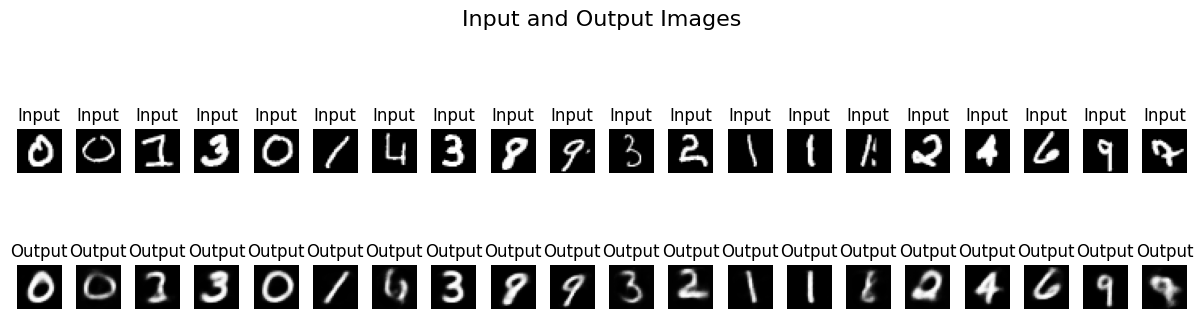

Configuration: num_layers=3, encoding_dim=50
Epoch [1/10], Training Loss: 0.2421, Validation Loss: 0.1433
Configuration: num_layers=3, encoding_dim=50
Epoch [2/10], Training Loss: 0.1339, Validation Loss: 0.0989
Configuration: num_layers=3, encoding_dim=50
Epoch [3/10], Training Loss: 0.1140, Validation Loss: 0.0858
Configuration: num_layers=3, encoding_dim=50
Epoch [4/10], Training Loss: 0.1058, Validation Loss: 0.0786
Configuration: num_layers=3, encoding_dim=50
Epoch [5/10], Training Loss: 0.1010, Validation Loss: 0.0756
Configuration: num_layers=3, encoding_dim=50
Epoch [6/10], Training Loss: 0.0981, Validation Loss: 0.0710
Configuration: num_layers=3, encoding_dim=50
Epoch [7/10], Training Loss: 0.0956, Validation Loss: 0.0693
Configuration: num_layers=3, encoding_dim=50
Epoch [8/10], Training Loss: 0.0940, Validation Loss: 0.0673
Configuration: num_layers=3, encoding_dim=50
Epoch [9/10], Training Loss: 0.0921, Validation Loss: 0.0661
Configuration: num_layers=3, encoding_dim=50
E

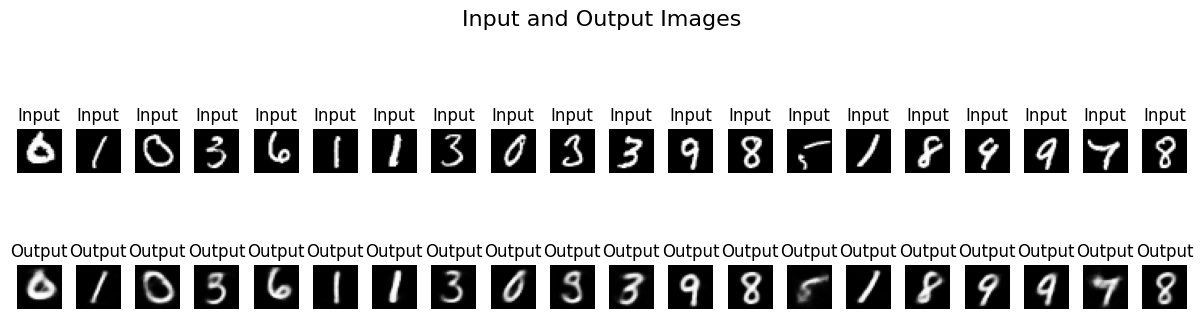

Configuration: num_layers=3, encoding_dim=100
Epoch [1/10], Training Loss: 0.2345, Validation Loss: 0.1356
Configuration: num_layers=3, encoding_dim=100
Epoch [2/10], Training Loss: 0.1287, Validation Loss: 0.0918
Configuration: num_layers=3, encoding_dim=100
Epoch [3/10], Training Loss: 0.1091, Validation Loss: 0.0804
Configuration: num_layers=3, encoding_dim=100
Epoch [4/10], Training Loss: 0.1019, Validation Loss: 0.0741
Configuration: num_layers=3, encoding_dim=100
Epoch [5/10], Training Loss: 0.0977, Validation Loss: 0.0711
Configuration: num_layers=3, encoding_dim=100
Epoch [6/10], Training Loss: 0.0945, Validation Loss: 0.0683
Configuration: num_layers=3, encoding_dim=100
Epoch [7/10], Training Loss: 0.0924, Validation Loss: 0.0652
Configuration: num_layers=3, encoding_dim=100
Epoch [8/10], Training Loss: 0.0906, Validation Loss: 0.0632
Configuration: num_layers=3, encoding_dim=100
Epoch [9/10], Training Loss: 0.0894, Validation Loss: 0.0625
Configuration: num_layers=3, encoding

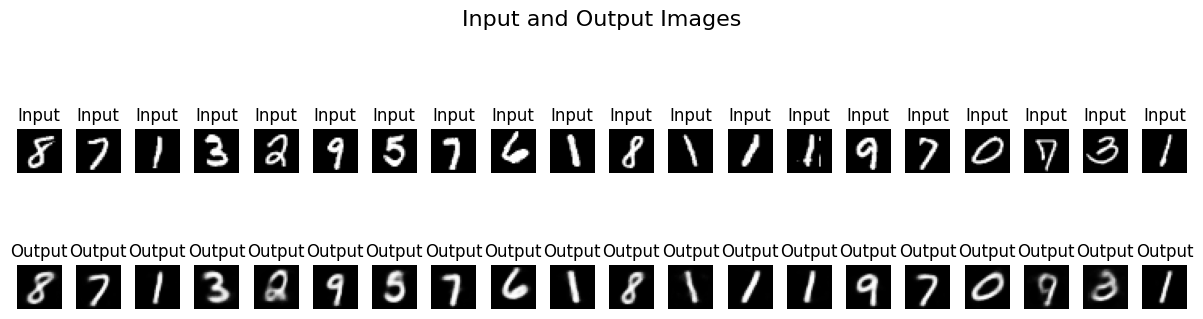

Configuration: num_layers=5, encoding_dim=15
Epoch [1/10], Training Loss: 0.2816, Validation Loss: 0.2711
Configuration: num_layers=5, encoding_dim=15
Epoch [2/10], Training Loss: 0.2675, Validation Loss: 0.2371
Configuration: num_layers=5, encoding_dim=15
Epoch [3/10], Training Loss: 0.2105, Validation Loss: 0.1857
Configuration: num_layers=5, encoding_dim=15
Epoch [4/10], Training Loss: 0.1843, Validation Loss: 0.1613
Configuration: num_layers=5, encoding_dim=15
Epoch [5/10], Training Loss: 0.1700, Validation Loss: 0.1506
Configuration: num_layers=5, encoding_dim=15
Epoch [6/10], Training Loss: 0.1628, Validation Loss: 0.1440
Configuration: num_layers=5, encoding_dim=15
Epoch [7/10], Training Loss: 0.1576, Validation Loss: 0.1376
Configuration: num_layers=5, encoding_dim=15
Epoch [8/10], Training Loss: 0.1532, Validation Loss: 0.1323
Configuration: num_layers=5, encoding_dim=15
Epoch [9/10], Training Loss: 0.1498, Validation Loss: 0.1291
Configuration: num_layers=5, encoding_dim=15
E

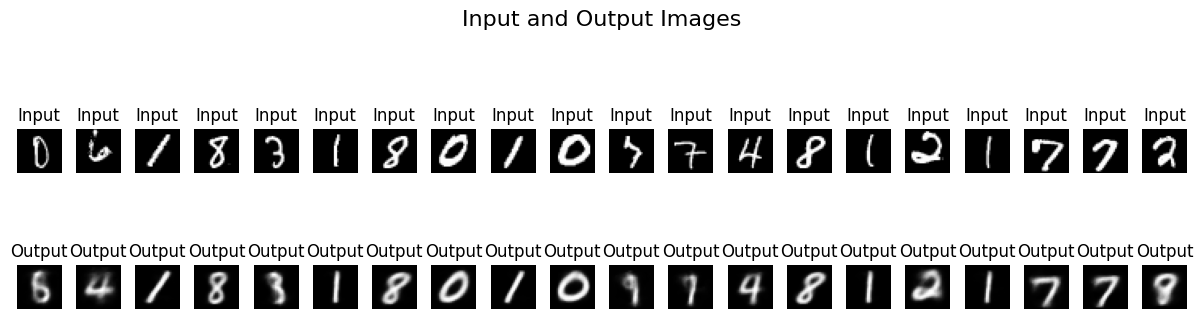

Configuration: num_layers=5, encoding_dim=30
Epoch [1/10], Training Loss: 0.2815, Validation Loss: 0.2708
Configuration: num_layers=5, encoding_dim=30
Epoch [2/10], Training Loss: 0.2589, Validation Loss: 0.2117
Configuration: num_layers=5, encoding_dim=30
Epoch [3/10], Training Loss: 0.1998, Validation Loss: 0.1774
Configuration: num_layers=5, encoding_dim=30
Epoch [4/10], Training Loss: 0.1737, Validation Loss: 0.1481
Configuration: num_layers=5, encoding_dim=30
Epoch [5/10], Training Loss: 0.1595, Validation Loss: 0.1384
Configuration: num_layers=5, encoding_dim=30
Epoch [6/10], Training Loss: 0.1546, Validation Loss: 0.1351
Configuration: num_layers=5, encoding_dim=30
Epoch [7/10], Training Loss: 0.1513, Validation Loss: 0.1309
Configuration: num_layers=5, encoding_dim=30
Epoch [8/10], Training Loss: 0.1481, Validation Loss: 0.1273
Configuration: num_layers=5, encoding_dim=30
Epoch [9/10], Training Loss: 0.1455, Validation Loss: 0.1232
Configuration: num_layers=5, encoding_dim=30
E

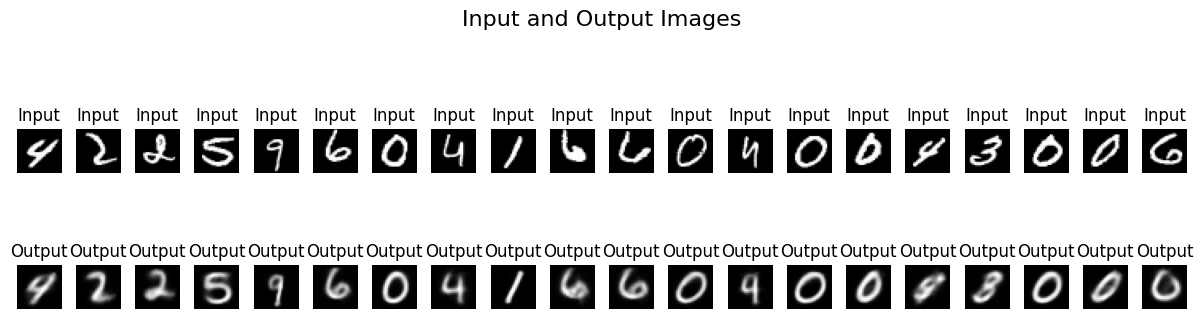

Configuration: num_layers=5, encoding_dim=50
Epoch [1/10], Training Loss: 0.2815, Validation Loss: 0.2709
Configuration: num_layers=5, encoding_dim=50
Epoch [2/10], Training Loss: 0.2522, Validation Loss: 0.2066
Configuration: num_layers=5, encoding_dim=50
Epoch [3/10], Training Loss: 0.1961, Validation Loss: 0.1697
Configuration: num_layers=5, encoding_dim=50
Epoch [4/10], Training Loss: 0.1715, Validation Loss: 0.1502
Configuration: num_layers=5, encoding_dim=50
Epoch [5/10], Training Loss: 0.1607, Validation Loss: 0.1395
Configuration: num_layers=5, encoding_dim=50
Epoch [6/10], Training Loss: 0.1530, Validation Loss: 0.1312
Configuration: num_layers=5, encoding_dim=50
Epoch [7/10], Training Loss: 0.1484, Validation Loss: 0.1279
Configuration: num_layers=5, encoding_dim=50
Epoch [8/10], Training Loss: 0.1454, Validation Loss: 0.1232
Configuration: num_layers=5, encoding_dim=50
Epoch [9/10], Training Loss: 0.1433, Validation Loss: 0.1204
Configuration: num_layers=5, encoding_dim=50
E

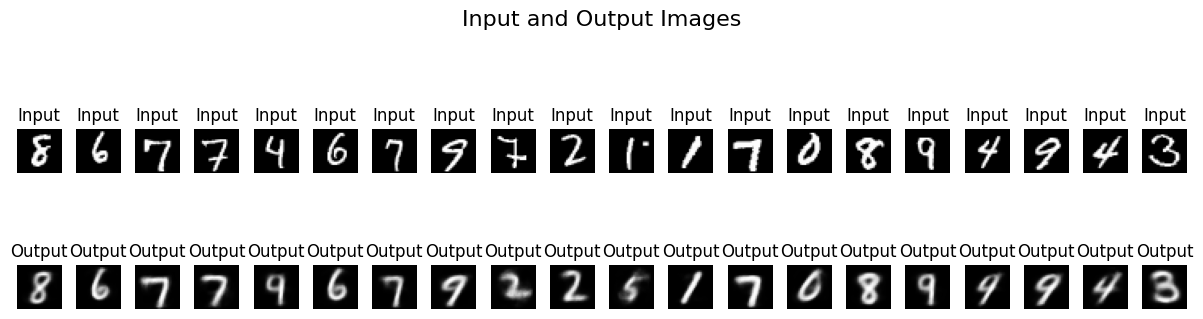

Configuration: num_layers=5, encoding_dim=100
Epoch [1/10], Training Loss: 0.2814, Validation Loss: 0.2706
Configuration: num_layers=5, encoding_dim=100
Epoch [2/10], Training Loss: 0.2681, Validation Loss: 0.2382
Configuration: num_layers=5, encoding_dim=100
Epoch [3/10], Training Loss: 0.2133, Validation Loss: 0.1868
Configuration: num_layers=5, encoding_dim=100
Epoch [4/10], Training Loss: 0.1837, Validation Loss: 0.1592
Configuration: num_layers=5, encoding_dim=100
Epoch [5/10], Training Loss: 0.1654, Validation Loss: 0.1431
Configuration: num_layers=5, encoding_dim=100
Epoch [6/10], Training Loss: 0.1553, Validation Loss: 0.1330
Configuration: num_layers=5, encoding_dim=100
Epoch [7/10], Training Loss: 0.1491, Validation Loss: 0.1268
Configuration: num_layers=5, encoding_dim=100
Epoch [8/10], Training Loss: 0.1453, Validation Loss: 0.1228
Configuration: num_layers=5, encoding_dim=100
Epoch [9/10], Training Loss: 0.1426, Validation Loss: 0.1207
Configuration: num_layers=5, encoding

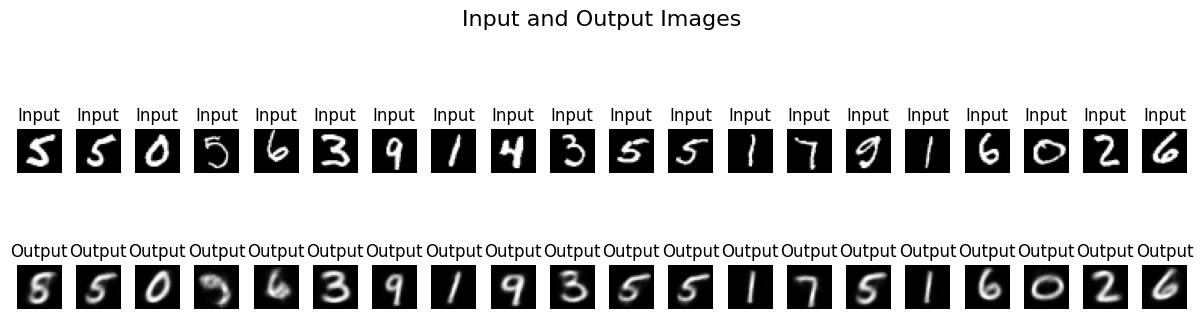

Best Validation Loss: 0.06140242558331229


In [ ]:
best_loss_dropout, best_model_dropout, losses_dropout = training_dropout(configurations, num_epochs, train_loader, test_dataset, dropout_prob, learning_rate)

In [ ]:
print('best_loss_dropout',best_loss_dropout)
print('best_model_dropout', best_model_dropout)

best_loss_dropout 0.06140242558331229
best_model_dropout Autoencoder_Dropout(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=512, out_features=128, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=128, out_features=100, bias=True)
    (7): Tanh()
  )
  (decoder): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=512, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=512, out_features=784, bias=True)
    (7): Tanh()
  )
)


### MNIST - LASSO

Configuration: num_layers=3, encoding_dim=15
Epoch [1/10], Training Loss: 0.2790, Validation Loss: 0.2710
Configuration: num_layers=3, encoding_dim=15
Epoch [2/10], Training Loss: 0.1782, Validation Loss: 0.1107
Configuration: num_layers=3, encoding_dim=15
Epoch [3/10], Training Loss: 0.0959, Validation Loss: 0.0835
Configuration: num_layers=3, encoding_dim=15
Epoch [4/10], Training Loss: 0.0791, Validation Loss: 0.0726
Configuration: num_layers=3, encoding_dim=15
Epoch [5/10], Training Loss: 0.0712, Validation Loss: 0.0668
Configuration: num_layers=3, encoding_dim=15
Epoch [6/10], Training Loss: 0.0662, Validation Loss: 0.0635
Configuration: num_layers=3, encoding_dim=15
Epoch [7/10], Training Loss: 0.0629, Validation Loss: 0.0604
Configuration: num_layers=3, encoding_dim=15
Epoch [8/10], Training Loss: 0.0603, Validation Loss: 0.0577
Configuration: num_layers=3, encoding_dim=15
Epoch [9/10], Training Loss: 0.0578, Validation Loss: 0.0565
Configuration: num_layers=3, encoding_dim=15
E

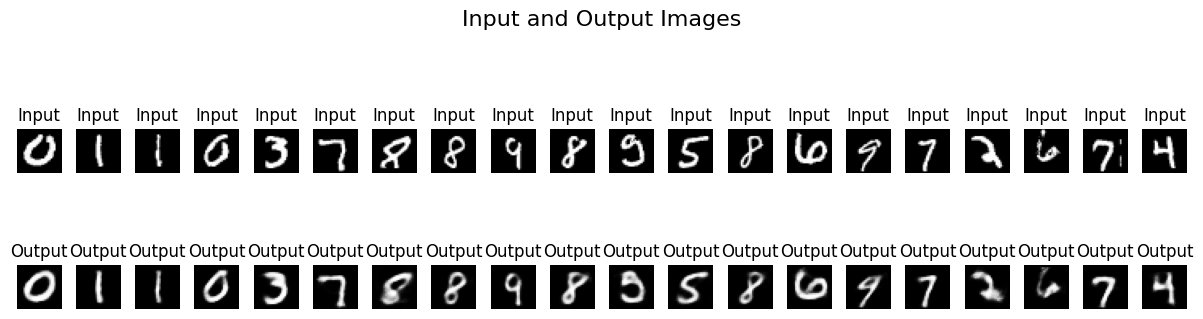

Configuration: num_layers=3, encoding_dim=30
Epoch [1/10], Training Loss: 0.2715, Validation Loss: 0.2304
Configuration: num_layers=3, encoding_dim=30
Epoch [2/10], Training Loss: 0.1402, Validation Loss: 0.0907
Configuration: num_layers=3, encoding_dim=30
Epoch [3/10], Training Loss: 0.0805, Validation Loss: 0.0684
Configuration: num_layers=3, encoding_dim=30
Epoch [4/10], Training Loss: 0.0654, Validation Loss: 0.0590
Configuration: num_layers=3, encoding_dim=30
Epoch [5/10], Training Loss: 0.0568, Validation Loss: 0.0517
Configuration: num_layers=3, encoding_dim=30
Epoch [6/10], Training Loss: 0.0513, Validation Loss: 0.0484
Configuration: num_layers=3, encoding_dim=30
Epoch [7/10], Training Loss: 0.0476, Validation Loss: 0.0449
Configuration: num_layers=3, encoding_dim=30
Epoch [8/10], Training Loss: 0.0452, Validation Loss: 0.0426
Configuration: num_layers=3, encoding_dim=30
Epoch [9/10], Training Loss: 0.0433, Validation Loss: 0.0410
Configuration: num_layers=3, encoding_dim=30
E

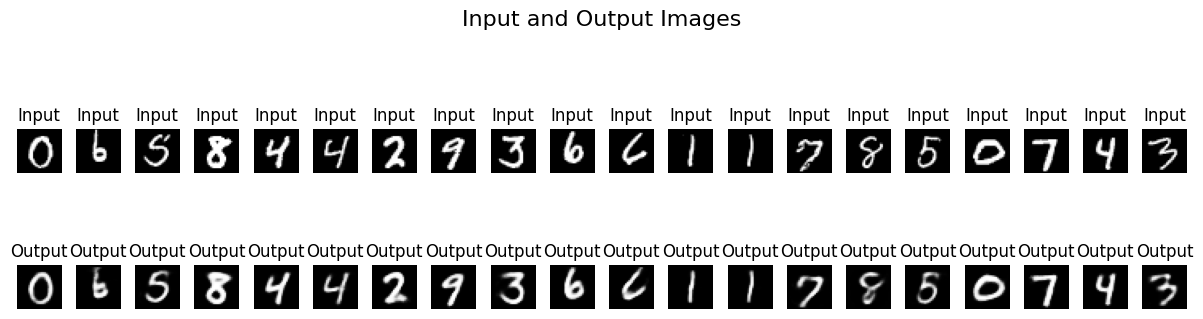

Configuration: num_layers=3, encoding_dim=50
Epoch [1/10], Training Loss: 0.2784, Validation Loss: 0.2709
Configuration: num_layers=3, encoding_dim=50
Epoch [2/10], Training Loss: 0.1758, Validation Loss: 0.0969
Configuration: num_layers=3, encoding_dim=50
Epoch [3/10], Training Loss: 0.0811, Validation Loss: 0.0675
Configuration: num_layers=3, encoding_dim=50
Epoch [4/10], Training Loss: 0.0627, Validation Loss: 0.0551
Configuration: num_layers=3, encoding_dim=50
Epoch [5/10], Training Loss: 0.0541, Validation Loss: 0.0495
Configuration: num_layers=3, encoding_dim=50
Epoch [6/10], Training Loss: 0.0495, Validation Loss: 0.0460
Configuration: num_layers=3, encoding_dim=50
Epoch [7/10], Training Loss: 0.0460, Validation Loss: 0.0433
Configuration: num_layers=3, encoding_dim=50
Epoch [8/10], Training Loss: 0.0433, Validation Loss: 0.0407
Configuration: num_layers=3, encoding_dim=50
Epoch [9/10], Training Loss: 0.0413, Validation Loss: 0.0396
Configuration: num_layers=3, encoding_dim=50
E

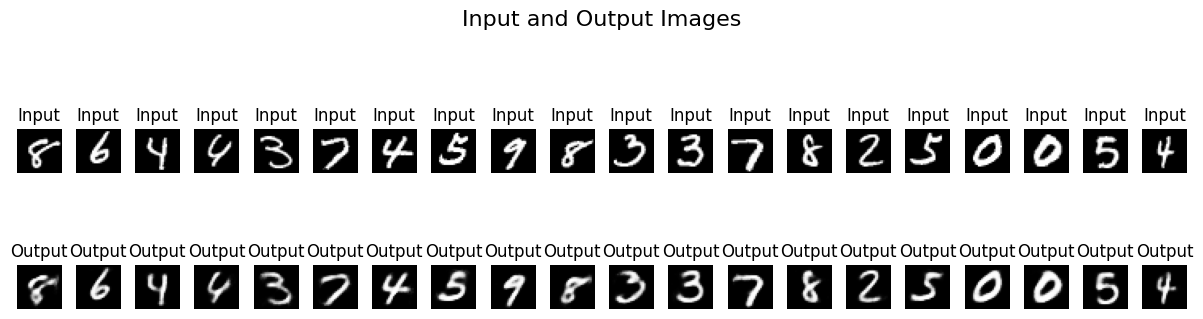

Configuration: num_layers=3, encoding_dim=100
Epoch [1/10], Training Loss: 0.2488, Validation Loss: 0.1857
Configuration: num_layers=3, encoding_dim=100
Epoch [2/10], Training Loss: 0.1189, Validation Loss: 0.0833
Configuration: num_layers=3, encoding_dim=100
Epoch [3/10], Training Loss: 0.0745, Validation Loss: 0.0632
Configuration: num_layers=3, encoding_dim=100
Epoch [4/10], Training Loss: 0.0584, Validation Loss: 0.0513
Configuration: num_layers=3, encoding_dim=100
Epoch [5/10], Training Loss: 0.0514, Validation Loss: 0.0468
Configuration: num_layers=3, encoding_dim=100
Epoch [6/10], Training Loss: 0.0472, Validation Loss: 0.0444
Configuration: num_layers=3, encoding_dim=100
Epoch [7/10], Training Loss: 0.0441, Validation Loss: 0.0411
Configuration: num_layers=3, encoding_dim=100
Epoch [8/10], Training Loss: 0.0417, Validation Loss: 0.0388
Configuration: num_layers=3, encoding_dim=100
Epoch [9/10], Training Loss: 0.0395, Validation Loss: 0.0372
Configuration: num_layers=3, encoding

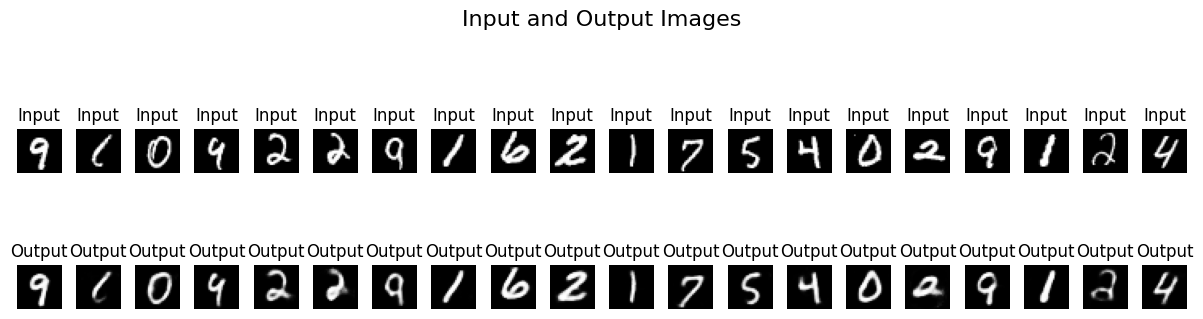

Configuration: num_layers=5, encoding_dim=15
Epoch [1/10], Training Loss: 0.2810, Validation Loss: 0.2706
Configuration: num_layers=5, encoding_dim=15
Epoch [2/10], Training Loss: 0.2336, Validation Loss: 0.1964
Configuration: num_layers=5, encoding_dim=15
Epoch [3/10], Training Loss: 0.1812, Validation Loss: 0.1597
Configuration: num_layers=5, encoding_dim=15
Epoch [4/10], Training Loss: 0.1493, Validation Loss: 0.1378
Configuration: num_layers=5, encoding_dim=15
Epoch [5/10], Training Loss: 0.1325, Validation Loss: 0.1261
Configuration: num_layers=5, encoding_dim=15
Epoch [6/10], Training Loss: 0.1202, Validation Loss: 0.1134
Configuration: num_layers=5, encoding_dim=15
Epoch [7/10], Training Loss: 0.1106, Validation Loss: 0.1053
Configuration: num_layers=5, encoding_dim=15
Epoch [8/10], Training Loss: 0.1037, Validation Loss: 0.1002
Configuration: num_layers=5, encoding_dim=15
Epoch [9/10], Training Loss: 0.0986, Validation Loss: 0.0954
Configuration: num_layers=5, encoding_dim=15
E

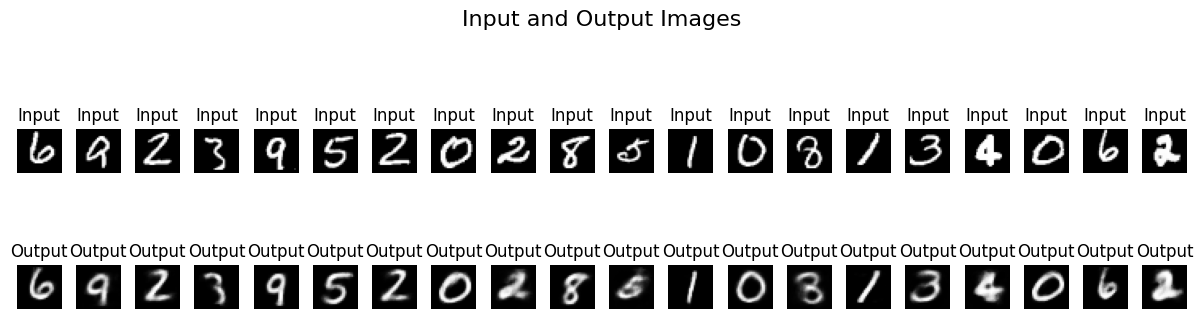

Configuration: num_layers=5, encoding_dim=30
Epoch [1/10], Training Loss: 0.2818, Validation Loss: 0.2712
Configuration: num_layers=5, encoding_dim=30
Epoch [2/10], Training Loss: 0.2144, Validation Loss: 0.1584
Configuration: num_layers=5, encoding_dim=30
Epoch [3/10], Training Loss: 0.1411, Validation Loss: 0.1266
Configuration: num_layers=5, encoding_dim=30
Epoch [4/10], Training Loss: 0.1204, Validation Loss: 0.1140
Configuration: num_layers=5, encoding_dim=30
Epoch [5/10], Training Loss: 0.1118, Validation Loss: 0.1082
Configuration: num_layers=5, encoding_dim=30
Epoch [6/10], Training Loss: 0.1059, Validation Loss: 0.1023
Configuration: num_layers=5, encoding_dim=30
Epoch [7/10], Training Loss: 0.1011, Validation Loss: 0.0981
Configuration: num_layers=5, encoding_dim=30
Epoch [8/10], Training Loss: 0.0969, Validation Loss: 0.0941
Configuration: num_layers=5, encoding_dim=30
Epoch [9/10], Training Loss: 0.0935, Validation Loss: 0.0910
Configuration: num_layers=5, encoding_dim=30
E

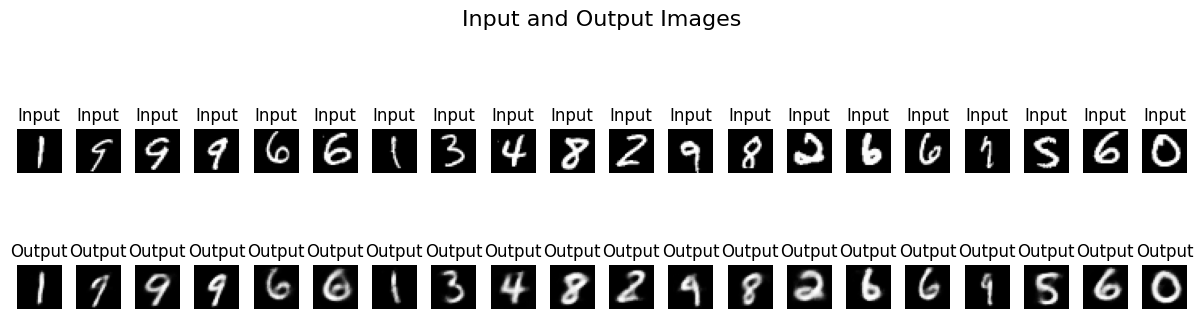

Configuration: num_layers=5, encoding_dim=50
Epoch [1/10], Training Loss: 0.2815, Validation Loss: 0.2709
Configuration: num_layers=5, encoding_dim=50
Epoch [2/10], Training Loss: 0.2492, Validation Loss: 0.2197
Configuration: num_layers=5, encoding_dim=50
Epoch [3/10], Training Loss: 0.1746, Validation Loss: 0.1543
Configuration: num_layers=5, encoding_dim=50
Epoch [4/10], Training Loss: 0.1474, Validation Loss: 0.1382
Configuration: num_layers=5, encoding_dim=50
Epoch [5/10], Training Loss: 0.1328, Validation Loss: 0.1233
Configuration: num_layers=5, encoding_dim=50
Epoch [6/10], Training Loss: 0.1183, Validation Loss: 0.1095
Configuration: num_layers=5, encoding_dim=50
Epoch [7/10], Training Loss: 0.1066, Validation Loss: 0.1016
Configuration: num_layers=5, encoding_dim=50
Epoch [8/10], Training Loss: 0.0996, Validation Loss: 0.0957
Configuration: num_layers=5, encoding_dim=50
Epoch [9/10], Training Loss: 0.0950, Validation Loss: 0.0928
Configuration: num_layers=5, encoding_dim=50
E

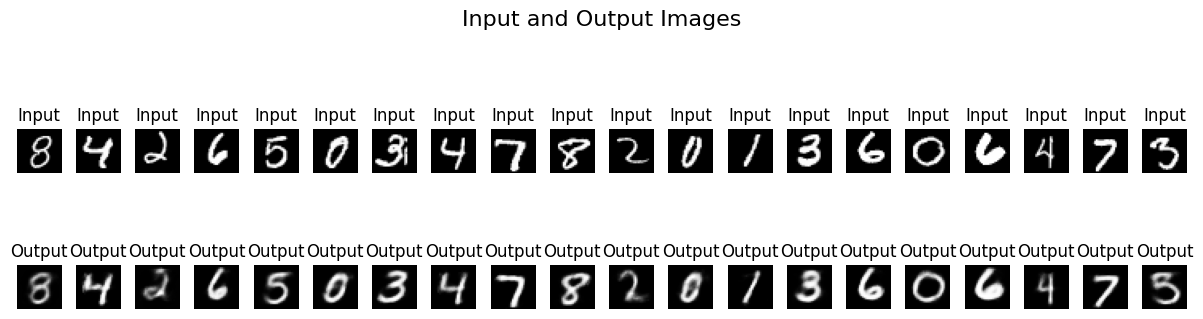

Configuration: num_layers=5, encoding_dim=100
Epoch [1/10], Training Loss: 0.2828, Validation Loss: 0.2706
Configuration: num_layers=5, encoding_dim=100
Epoch [2/10], Training Loss: 0.2340, Validation Loss: 0.1925
Configuration: num_layers=5, encoding_dim=100
Epoch [3/10], Training Loss: 0.1736, Validation Loss: 0.1465
Configuration: num_layers=5, encoding_dim=100
Epoch [4/10], Training Loss: 0.1327, Validation Loss: 0.1205
Configuration: num_layers=5, encoding_dim=100
Epoch [5/10], Training Loss: 0.1135, Validation Loss: 0.1038
Configuration: num_layers=5, encoding_dim=100
Epoch [6/10], Training Loss: 0.1000, Validation Loss: 0.0942
Configuration: num_layers=5, encoding_dim=100
Epoch [7/10], Training Loss: 0.0926, Validation Loss: 0.0885
Configuration: num_layers=5, encoding_dim=100
Epoch [8/10], Training Loss: 0.0878, Validation Loss: 0.0843
Configuration: num_layers=5, encoding_dim=100
Epoch [9/10], Training Loss: 0.0839, Validation Loss: 0.0804
Configuration: num_layers=5, encoding

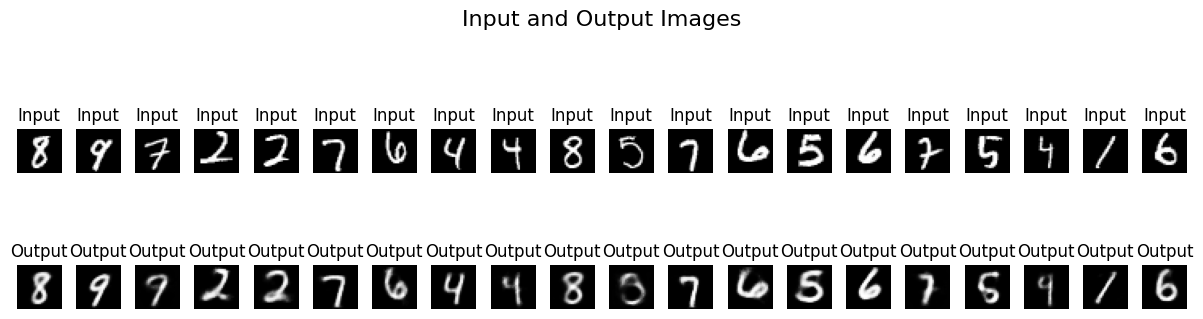

Best Validation Loss: 0.035771473469538614


In [ ]:
best_loss_lasso, best_model_lasso, losses_lasso = training_lasso(configurations,num_epochs, train_loader,test_dataset, lasso_lambda, learning_rate)

In [ ]:
print('best_loss_lasso',best_loss_lasso)
print('best_model_lasso', best_model_lasso)

best_loss_lasso 0.035771473469538614
best_model_lasso Autoencoder_Lasso(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=512, out_features=128, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=128, out_features=100, bias=True)
    (5): Tanh()
  )
  (decoder): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=512, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=512, out_features=784, bias=True)
    (5): Tanh()
  )
)


### Plot Comparison of Regularization Techniques

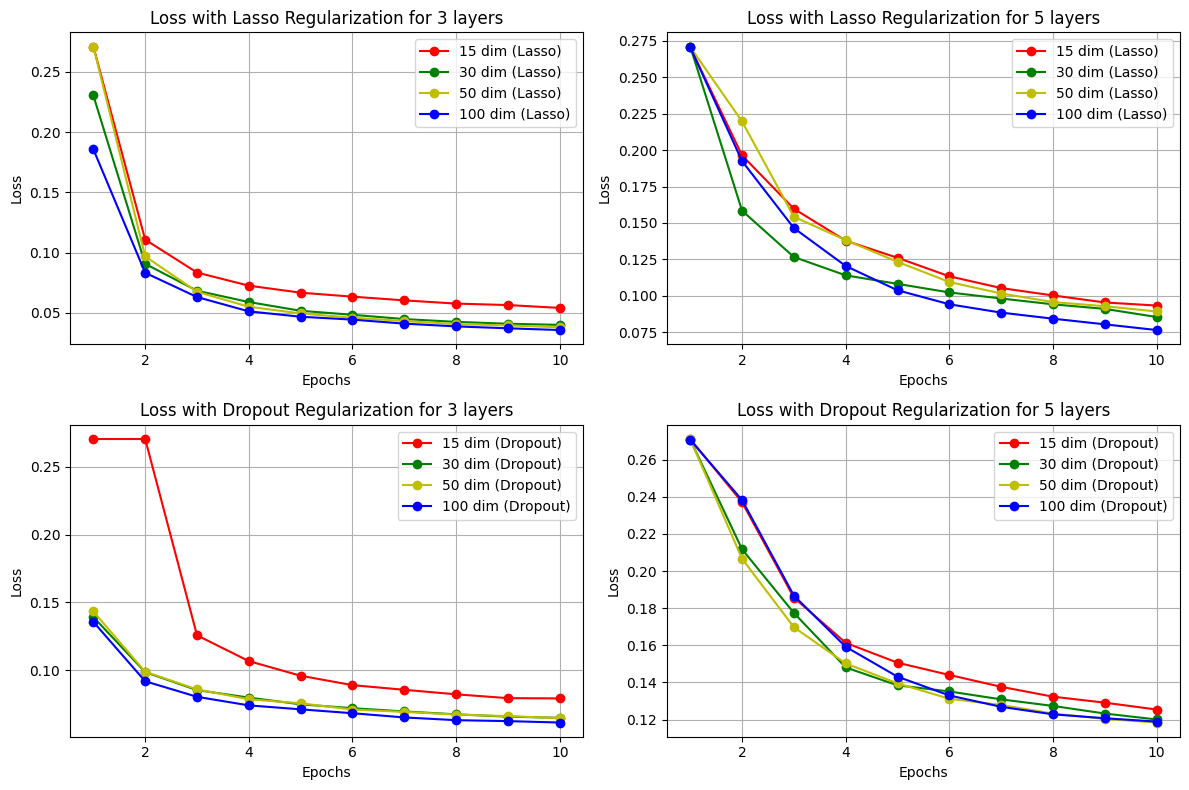

In [ ]:
plot_loss(num_epochs, losses_lasso, losses_dropout)

### MNIST - Denoising

Training with noise variance: 0.1
Epoch [1/10], Loss: 0.1729, PSNR: 6.2651, Validation PSNR: 7.6294
Epoch [2/10], Loss: 0.0961, PSNR: 9.4076, Validation PSNR: 10.7033
Epoch [3/10], Loss: 0.0655, PSNR: 11.2119, Validation PSNR: 11.8623
Epoch [4/10], Loss: 0.0583, PSNR: 12.1526, Validation PSNR: 12.6573
Epoch [5/10], Loss: 0.0504, PSNR: 12.7596, Validation PSNR: 13.0812
Epoch [6/10], Loss: 0.0464, PSNR: 13.1619, Validation PSNR: 13.5003
Epoch [7/10], Loss: 0.0416, PSNR: 13.4919, Validation PSNR: 13.6985
Epoch [8/10], Loss: 0.0447, PSNR: 13.7270, Validation PSNR: 13.9705
Epoch [9/10], Loss: 0.0392, PSNR: 13.9571, Validation PSNR: 14.1682
Epoch [10/10], Loss: 0.0379, PSNR: 14.1717, Validation PSNR: 14.3820


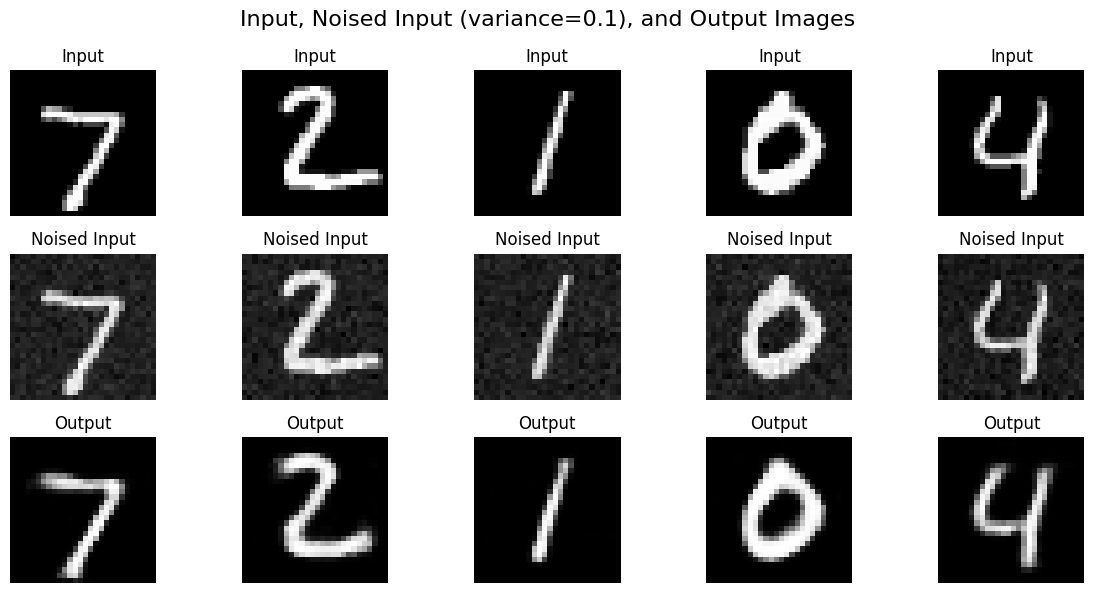

Training with noise variance: 0.25
Epoch [1/10], Loss: 0.2215, PSNR: 5.7874, Validation PSNR: 6.7211
Epoch [2/10], Loss: 0.0922, PSNR: 8.7361, Validation PSNR: 10.2214
Epoch [3/10], Loss: 0.0636, PSNR: 11.0221, Validation PSNR: 11.8084
Epoch [4/10], Loss: 0.0550, PSNR: 12.1316, Validation PSNR: 12.6671
Epoch [5/10], Loss: 0.0516, PSNR: 12.7475, Validation PSNR: 13.1477
Epoch [6/10], Loss: 0.0490, PSNR: 13.1416, Validation PSNR: 13.4923
Epoch [7/10], Loss: 0.0448, PSNR: 13.4490, Validation PSNR: 13.7459
Epoch [8/10], Loss: 0.0394, PSNR: 13.6946, Validation PSNR: 13.8558
Epoch [9/10], Loss: 0.0465, PSNR: 13.9209, Validation PSNR: 14.0811
Epoch [10/10], Loss: 0.0387, PSNR: 14.1277, Validation PSNR: 14.2587


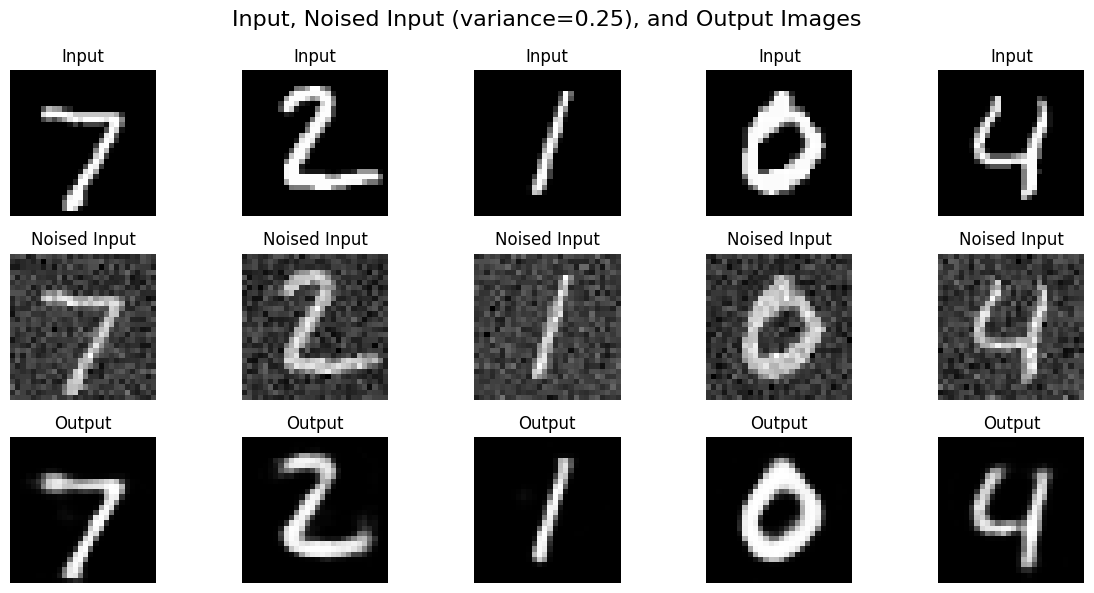

Training with noise variance: 0.5
Epoch [1/10], Loss: 0.1974, PSNR: 6.0230, Validation PSNR: 7.2171
Epoch [2/10], Loss: 0.0901, PSNR: 9.2129, Validation PSNR: 10.4340
Epoch [3/10], Loss: 0.0805, PSNR: 10.8681, Validation PSNR: 11.4149
Epoch [4/10], Loss: 0.0626, PSNR: 11.6015, Validation PSNR: 12.0402
Epoch [5/10], Loss: 0.0617, PSNR: 12.1096, Validation PSNR: 12.4326
Epoch [6/10], Loss: 0.0591, PSNR: 12.4877, Validation PSNR: 12.7712
Epoch [7/10], Loss: 0.0562, PSNR: 12.7543, Validation PSNR: 13.0095
Epoch [8/10], Loss: 0.0507, PSNR: 12.9769, Validation PSNR: 13.2027
Epoch [9/10], Loss: 0.0486, PSNR: 13.1780, Validation PSNR: 13.3685
Epoch [10/10], Loss: 0.0488, PSNR: 13.3471, Validation PSNR: 13.5027


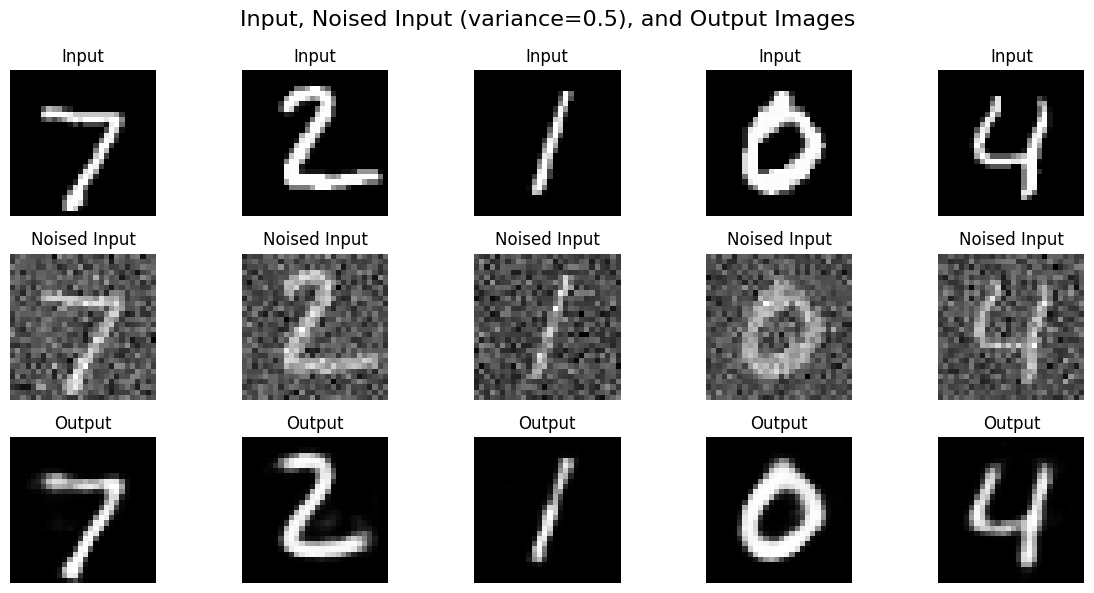

Training with noise variance: 0.75
Epoch [1/10], Loss: 0.1956, PSNR: 6.0604, Validation PSNR: 7.2776
Epoch [2/10], Loss: 0.0955, PSNR: 9.0737, Validation PSNR: 10.2850
Epoch [3/10], Loss: 0.0752, PSNR: 10.6443, Validation PSNR: 11.1208
Epoch [4/10], Loss: 0.0792, PSNR: 11.3301, Validation PSNR: 11.6672
Epoch [5/10], Loss: 0.0678, PSNR: 11.7858, Validation PSNR: 12.0842
Epoch [6/10], Loss: 0.0649, PSNR: 12.0660, Validation PSNR: 12.2638
Epoch [7/10], Loss: 0.0621, PSNR: 12.2784, Validation PSNR: 12.4505
Epoch [8/10], Loss: 0.0562, PSNR: 12.4365, Validation PSNR: 12.6113
Epoch [9/10], Loss: 0.0551, PSNR: 12.6102, Validation PSNR: 12.7602
Epoch [10/10], Loss: 0.0503, PSNR: 12.7543, Validation PSNR: 12.9178


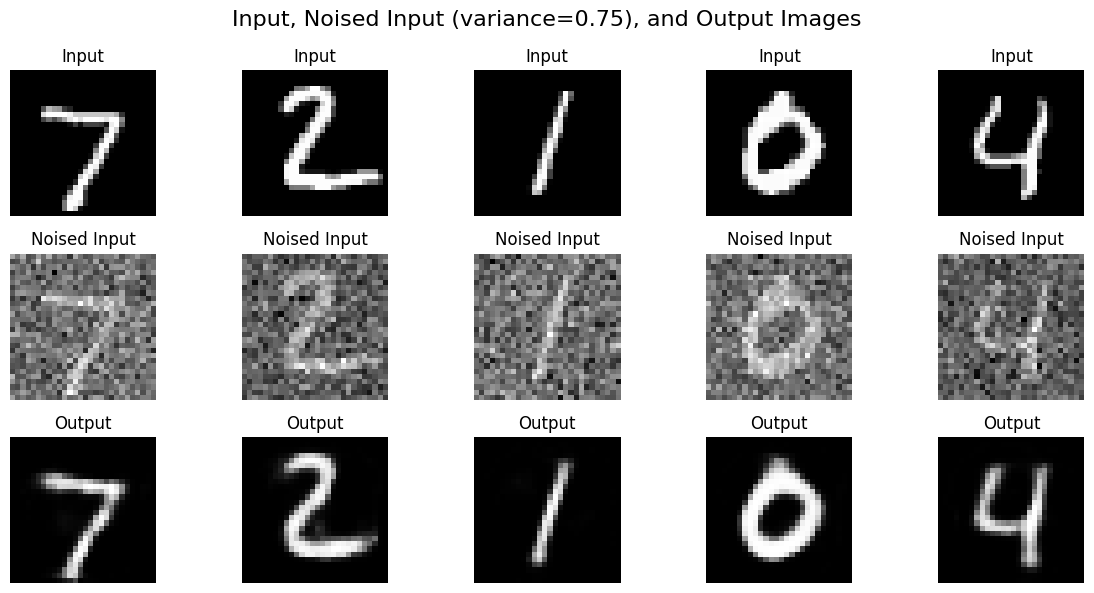

Training with noise variance: 1
Epoch [1/10], Loss: 0.1838, PSNR: 6.2538, Validation PSNR: 7.5557
Epoch [2/10], Loss: 0.0936, PSNR: 9.1139, Validation PSNR: 10.0139
Epoch [3/10], Loss: 0.0854, PSNR: 10.3311, Validation PSNR: 10.7432
Epoch [4/10], Loss: 0.0829, PSNR: 10.8471, Validation PSNR: 11.1264
Epoch [5/10], Loss: 0.0701, PSNR: 11.1681, Validation PSNR: 11.3943
Epoch [6/10], Loss: 0.0707, PSNR: 11.4083, Validation PSNR: 11.6037
Epoch [7/10], Loss: 0.0650, PSNR: 11.5798, Validation PSNR: 11.7568
Epoch [8/10], Loss: 0.0676, PSNR: 11.7495, Validation PSNR: 11.8305
Epoch [9/10], Loss: 0.0642, PSNR: 11.8661, Validation PSNR: 11.9672
Epoch [10/10], Loss: 0.0581, PSNR: 11.9727, Validation PSNR: 12.1077


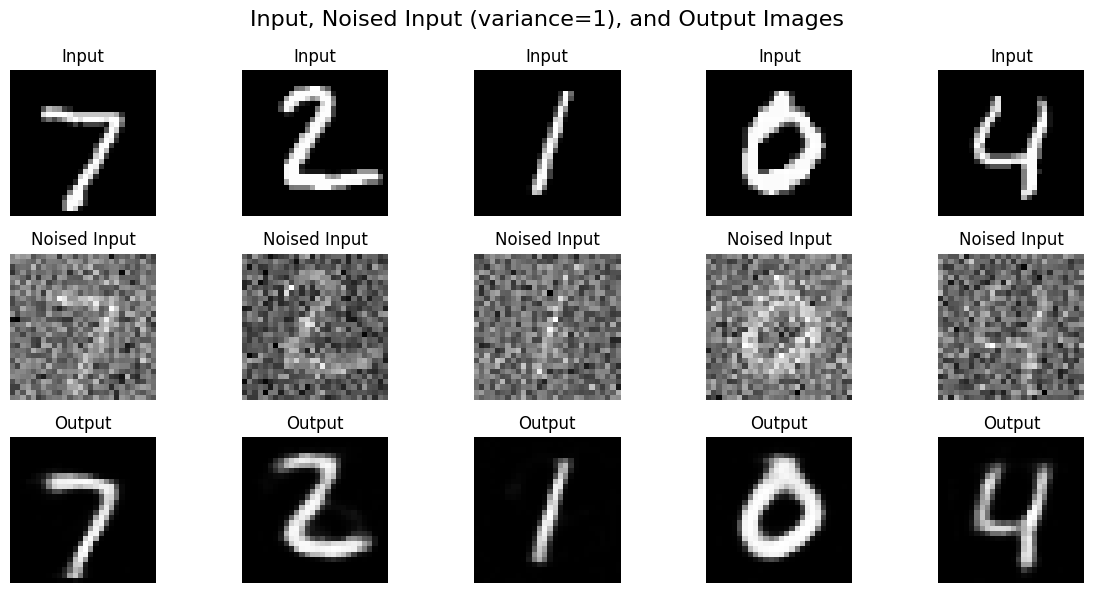

In [ ]:
psnr_dict = training_denoising(learning_rate, num_epochs, best_model_lasso, noise_variances, train_loader, test_loader)

### Plot PSNR evolution among different variances

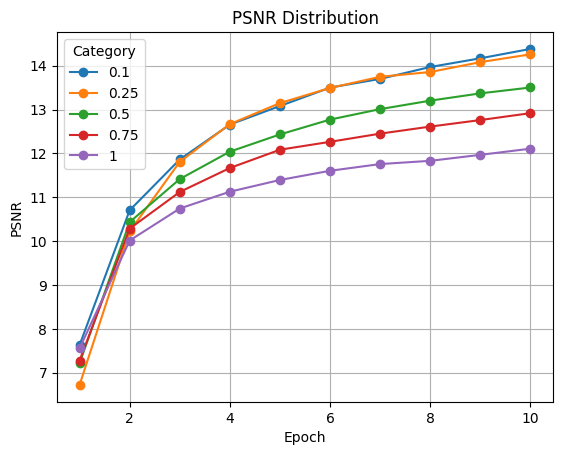

In [ ]:
plot_denoising(psnr_dict)

# FMNIST

In [ ]:
####  FMNIST  ####

# Download and load the training data
trainset = torchvision.datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
train_loader2 = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = torchvision.datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
test_loader2 = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)


# Define a transformation pipeline for image preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalize the image tensor with mean and standard deviation
])

100%|██████████| 26421880/26421880 [00:02<00:00, 10136206.60it/s]


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 171373.95it/s]


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3151036.97it/s]


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 5999521.25it/s]

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



### FMNIST - DROPOUT

Configuration: num_layers=3, encoding_dim=15
Epoch [1/10], Training Loss: 0.1261, Validation Loss: 0.0873
Configuration: num_layers=3, encoding_dim=15
Epoch [2/10], Training Loss: 0.0947, Validation Loss: 0.0803
Configuration: num_layers=3, encoding_dim=15
Epoch [3/10], Training Loss: 0.0893, Validation Loss: 0.0747
Configuration: num_layers=3, encoding_dim=15
Epoch [4/10], Training Loss: 0.0859, Validation Loss: 0.0730
Configuration: num_layers=3, encoding_dim=15
Epoch [5/10], Training Loss: 0.0839, Validation Loss: 0.0704
Configuration: num_layers=3, encoding_dim=15
Epoch [6/10], Training Loss: 0.0825, Validation Loss: 0.0689
Configuration: num_layers=3, encoding_dim=15
Epoch [7/10], Training Loss: 0.0813, Validation Loss: 0.0685
Configuration: num_layers=3, encoding_dim=15
Epoch [8/10], Training Loss: 0.0806, Validation Loss: 0.0667
Configuration: num_layers=3, encoding_dim=15
Epoch [9/10], Training Loss: 0.0797, Validation Loss: 0.0668
Configuration: num_layers=3, encoding_dim=15
E

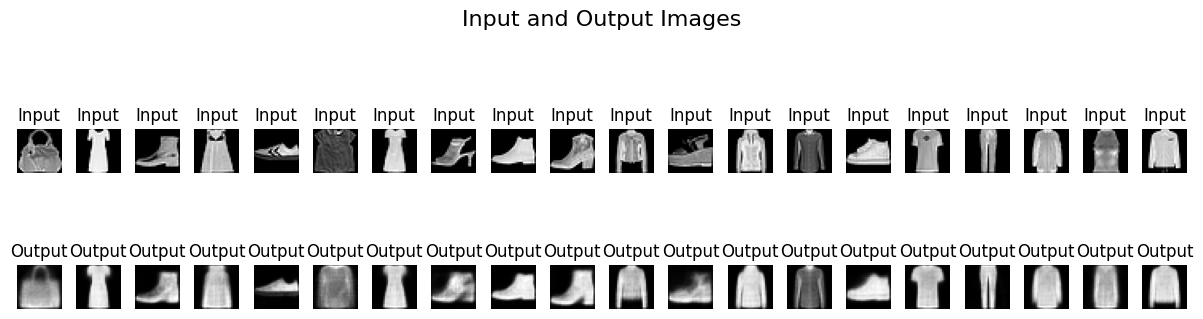

Configuration: num_layers=3, encoding_dim=30
Epoch [1/10], Training Loss: 0.1253, Validation Loss: 0.0836
Configuration: num_layers=3, encoding_dim=30
Epoch [2/10], Training Loss: 0.0915, Validation Loss: 0.0756
Configuration: num_layers=3, encoding_dim=30
Epoch [3/10], Training Loss: 0.0864, Validation Loss: 0.0724
Configuration: num_layers=3, encoding_dim=30
Epoch [4/10], Training Loss: 0.0837, Validation Loss: 0.0703
Configuration: num_layers=3, encoding_dim=30
Epoch [5/10], Training Loss: 0.0819, Validation Loss: 0.0690
Configuration: num_layers=3, encoding_dim=30
Epoch [6/10], Training Loss: 0.0806, Validation Loss: 0.0671
Configuration: num_layers=3, encoding_dim=30
Epoch [7/10], Training Loss: 0.0795, Validation Loss: 0.0663
Configuration: num_layers=3, encoding_dim=30
Epoch [8/10], Training Loss: 0.0786, Validation Loss: 0.0659
Configuration: num_layers=3, encoding_dim=30
Epoch [9/10], Training Loss: 0.0779, Validation Loss: 0.0645
Configuration: num_layers=3, encoding_dim=30
E

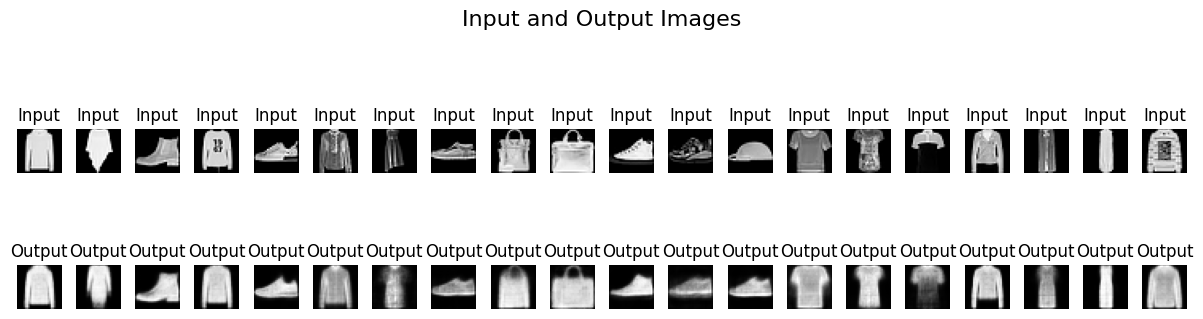

Configuration: num_layers=3, encoding_dim=50
Epoch [1/10], Training Loss: 0.1221, Validation Loss: 0.0828
Configuration: num_layers=3, encoding_dim=50
Epoch [2/10], Training Loss: 0.0904, Validation Loss: 0.0756
Configuration: num_layers=3, encoding_dim=50
Epoch [3/10], Training Loss: 0.0852, Validation Loss: 0.0716
Configuration: num_layers=3, encoding_dim=50
Epoch [4/10], Training Loss: 0.0824, Validation Loss: 0.0685
Configuration: num_layers=3, encoding_dim=50
Epoch [5/10], Training Loss: 0.0805, Validation Loss: 0.0675
Configuration: num_layers=3, encoding_dim=50
Epoch [6/10], Training Loss: 0.0790, Validation Loss: 0.0662
Configuration: num_layers=3, encoding_dim=50
Epoch [7/10], Training Loss: 0.0780, Validation Loss: 0.0643
Configuration: num_layers=3, encoding_dim=50
Epoch [8/10], Training Loss: 0.0773, Validation Loss: 0.0653
Configuration: num_layers=3, encoding_dim=50
Epoch [9/10], Training Loss: 0.0765, Validation Loss: 0.0632
Configuration: num_layers=3, encoding_dim=50
E

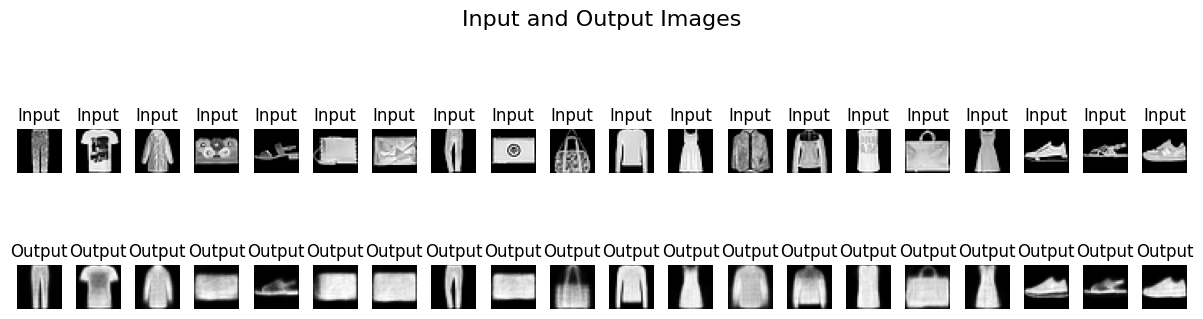

Configuration: num_layers=3, encoding_dim=100
Epoch [1/10], Training Loss: 0.1209, Validation Loss: 0.0817
Configuration: num_layers=3, encoding_dim=100
Epoch [2/10], Training Loss: 0.0897, Validation Loss: 0.0741
Configuration: num_layers=3, encoding_dim=100
Epoch [3/10], Training Loss: 0.0847, Validation Loss: 0.0703
Configuration: num_layers=3, encoding_dim=100
Epoch [4/10], Training Loss: 0.0818, Validation Loss: 0.0674
Configuration: num_layers=3, encoding_dim=100
Epoch [5/10], Training Loss: 0.0800, Validation Loss: 0.0660
Configuration: num_layers=3, encoding_dim=100
Epoch [6/10], Training Loss: 0.0788, Validation Loss: 0.0649
Configuration: num_layers=3, encoding_dim=100
Epoch [7/10], Training Loss: 0.0777, Validation Loss: 0.0636
Configuration: num_layers=3, encoding_dim=100
Epoch [8/10], Training Loss: 0.0769, Validation Loss: 0.0629
Configuration: num_layers=3, encoding_dim=100
Epoch [9/10], Training Loss: 0.0761, Validation Loss: 0.0625
Configuration: num_layers=3, encoding

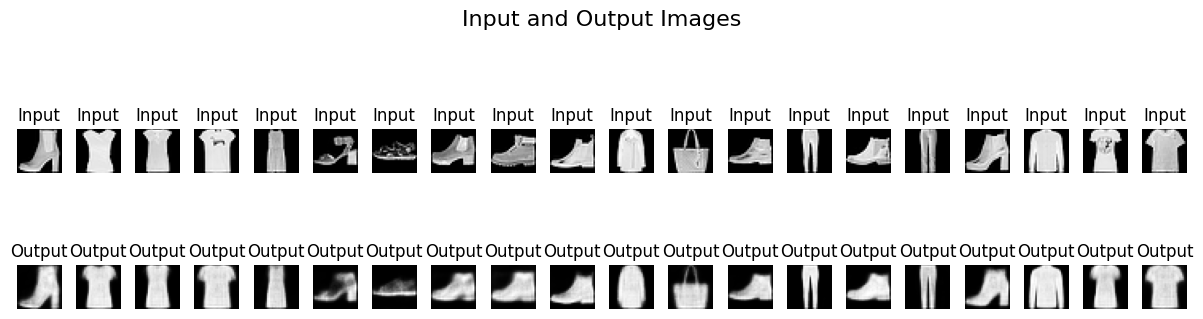

Configuration: num_layers=5, encoding_dim=15
Epoch [1/10], Training Loss: 0.1735, Validation Loss: 0.1237
Configuration: num_layers=5, encoding_dim=15
Epoch [2/10], Training Loss: 0.1286, Validation Loss: 0.1103
Configuration: num_layers=5, encoding_dim=15
Epoch [3/10], Training Loss: 0.1211, Validation Loss: 0.1065
Configuration: num_layers=5, encoding_dim=15
Epoch [4/10], Training Loss: 0.1184, Validation Loss: 0.1041
Configuration: num_layers=5, encoding_dim=15
Epoch [5/10], Training Loss: 0.1157, Validation Loss: 0.1016
Configuration: num_layers=5, encoding_dim=15
Epoch [6/10], Training Loss: 0.1137, Validation Loss: 0.1002
Configuration: num_layers=5, encoding_dim=15
Epoch [7/10], Training Loss: 0.1124, Validation Loss: 0.0989
Configuration: num_layers=5, encoding_dim=15
Epoch [8/10], Training Loss: 0.1111, Validation Loss: 0.0966
Configuration: num_layers=5, encoding_dim=15
Epoch [9/10], Training Loss: 0.1100, Validation Loss: 0.0953
Configuration: num_layers=5, encoding_dim=15
E

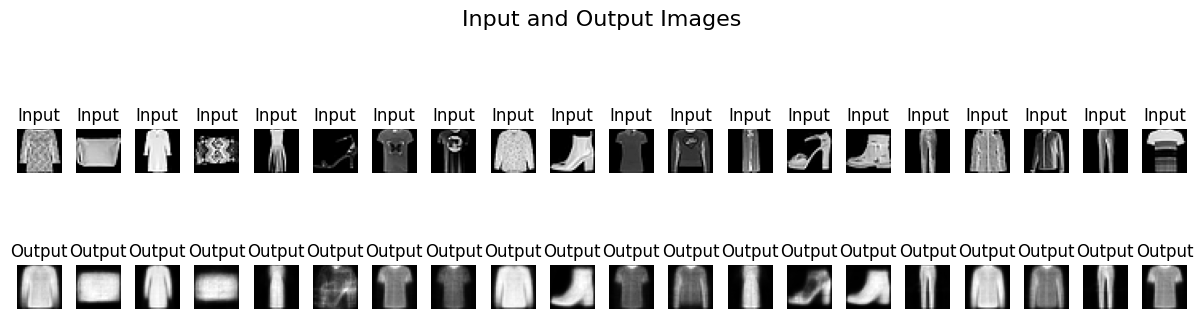

Configuration: num_layers=5, encoding_dim=30
Epoch [1/10], Training Loss: 0.1695, Validation Loss: 0.1206
Configuration: num_layers=5, encoding_dim=30
Epoch [2/10], Training Loss: 0.1248, Validation Loss: 0.1065
Configuration: num_layers=5, encoding_dim=30
Epoch [3/10], Training Loss: 0.1182, Validation Loss: 0.1028
Configuration: num_layers=5, encoding_dim=30
Epoch [4/10], Training Loss: 0.1152, Validation Loss: 0.1024
Configuration: num_layers=5, encoding_dim=30
Epoch [5/10], Training Loss: 0.1131, Validation Loss: 0.1008
Configuration: num_layers=5, encoding_dim=30
Epoch [6/10], Training Loss: 0.1120, Validation Loss: 0.0980
Configuration: num_layers=5, encoding_dim=30
Epoch [7/10], Training Loss: 0.1105, Validation Loss: 0.0976
Configuration: num_layers=5, encoding_dim=30
Epoch [8/10], Training Loss: 0.1098, Validation Loss: 0.0960
Configuration: num_layers=5, encoding_dim=30
Epoch [9/10], Training Loss: 0.1086, Validation Loss: 0.0946
Configuration: num_layers=5, encoding_dim=30
E

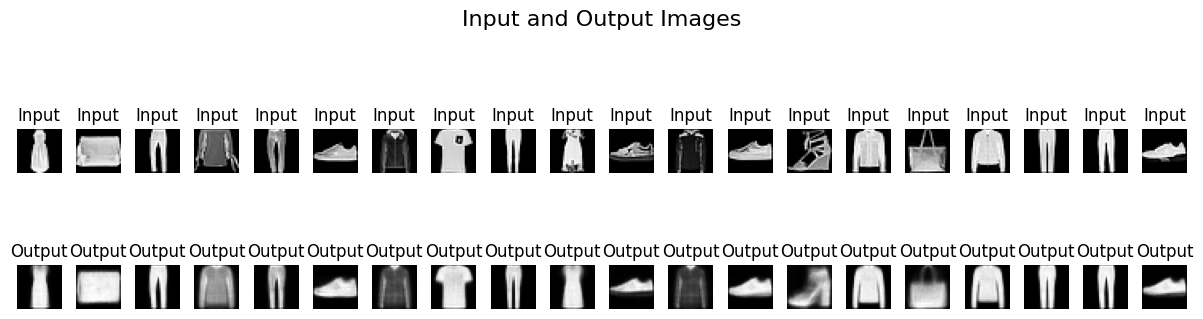

Configuration: num_layers=5, encoding_dim=50
Epoch [1/10], Training Loss: 0.1693, Validation Loss: 0.1195
Configuration: num_layers=5, encoding_dim=50
Epoch [2/10], Training Loss: 0.1250, Validation Loss: 0.1063
Configuration: num_layers=5, encoding_dim=50
Epoch [3/10], Training Loss: 0.1182, Validation Loss: 0.1036
Configuration: num_layers=5, encoding_dim=50
Epoch [4/10], Training Loss: 0.1158, Validation Loss: 0.1021
Configuration: num_layers=5, encoding_dim=50
Epoch [5/10], Training Loss: 0.1140, Validation Loss: 0.1008
Configuration: num_layers=5, encoding_dim=50
Epoch [6/10], Training Loss: 0.1121, Validation Loss: 0.0990
Configuration: num_layers=5, encoding_dim=50
Epoch [7/10], Training Loss: 0.1111, Validation Loss: 0.0983
Configuration: num_layers=5, encoding_dim=50
Epoch [8/10], Training Loss: 0.1104, Validation Loss: 0.0968
Configuration: num_layers=5, encoding_dim=50
Epoch [9/10], Training Loss: 0.1092, Validation Loss: 0.0960
Configuration: num_layers=5, encoding_dim=50
E

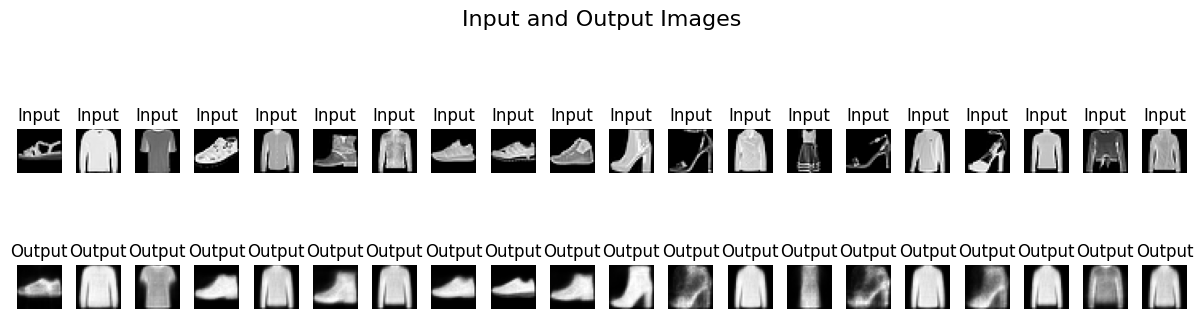

Configuration: num_layers=5, encoding_dim=100
Epoch [1/10], Training Loss: 0.1704, Validation Loss: 0.1205
Configuration: num_layers=5, encoding_dim=100
Epoch [2/10], Training Loss: 0.1245, Validation Loss: 0.1057
Configuration: num_layers=5, encoding_dim=100
Epoch [3/10], Training Loss: 0.1176, Validation Loss: 0.1033
Configuration: num_layers=5, encoding_dim=100
Epoch [4/10], Training Loss: 0.1147, Validation Loss: 0.1008
Configuration: num_layers=5, encoding_dim=100
Epoch [5/10], Training Loss: 0.1133, Validation Loss: 0.0990
Configuration: num_layers=5, encoding_dim=100
Epoch [6/10], Training Loss: 0.1116, Validation Loss: 0.0978
Configuration: num_layers=5, encoding_dim=100
Epoch [7/10], Training Loss: 0.1106, Validation Loss: 0.0972
Configuration: num_layers=5, encoding_dim=100
Epoch [8/10], Training Loss: 0.1091, Validation Loss: 0.0968
Configuration: num_layers=5, encoding_dim=100
Epoch [9/10], Training Loss: 0.1085, Validation Loss: 0.0937
Configuration: num_layers=5, encoding

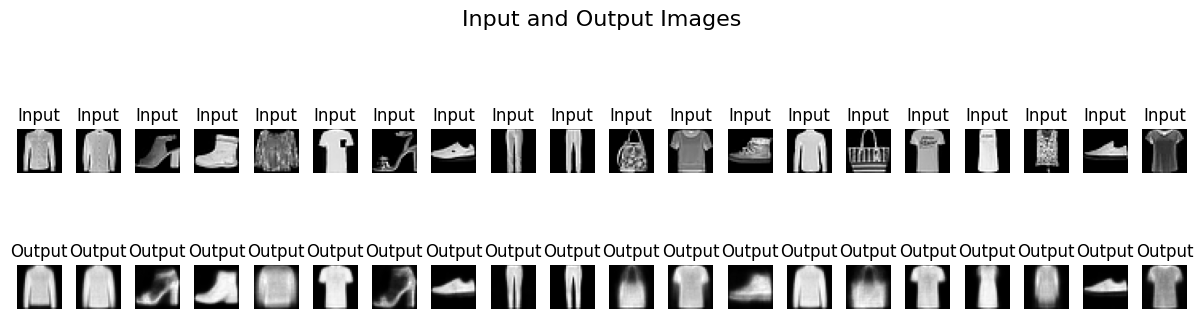

Best Validation Loss: 0.062169397189933806


In [ ]:
best_loss_dropout2, best_model_dropout2, losses_dropout2 = training_dropout(configurations,num_epochs, train_loader2, testset, dropout_prob, learning_rate)

In [ ]:
print('best_loss_dropout2',best_loss_dropout2)
print('best_model_dropout2', best_model_dropout2)

best_loss_dropout2 0.062169397189933806
best_model_dropout2 Autoencoder_Dropout(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=512, out_features=128, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=128, out_features=100, bias=True)
    (7): Tanh()
  )
  (decoder): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=512, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=512, out_features=784, bias=True)
    (7): Tanh()
  )
)


### FMNIST - LASSO

Configuration: num_layers=3, encoding_dim=15
Epoch [1/10], Training Loss: 0.0990, Validation Loss: 0.0679
Configuration: num_layers=3, encoding_dim=15
Epoch [2/10], Training Loss: 0.0624, Validation Loss: 0.0580
Configuration: num_layers=3, encoding_dim=15
Epoch [3/10], Training Loss: 0.0559, Validation Loss: 0.0538
Configuration: num_layers=3, encoding_dim=15
Epoch [4/10], Training Loss: 0.0527, Validation Loss: 0.0520
Configuration: num_layers=3, encoding_dim=15
Epoch [5/10], Training Loss: 0.0506, Validation Loss: 0.0510
Configuration: num_layers=3, encoding_dim=15
Epoch [6/10], Training Loss: 0.0492, Validation Loss: 0.0491
Configuration: num_layers=3, encoding_dim=15
Epoch [7/10], Training Loss: 0.0482, Validation Loss: 0.0484
Configuration: num_layers=3, encoding_dim=15
Epoch [8/10], Training Loss: 0.0475, Validation Loss: 0.0480
Configuration: num_layers=3, encoding_dim=15
Epoch [9/10], Training Loss: 0.0469, Validation Loss: 0.0469
Configuration: num_layers=3, encoding_dim=15
E

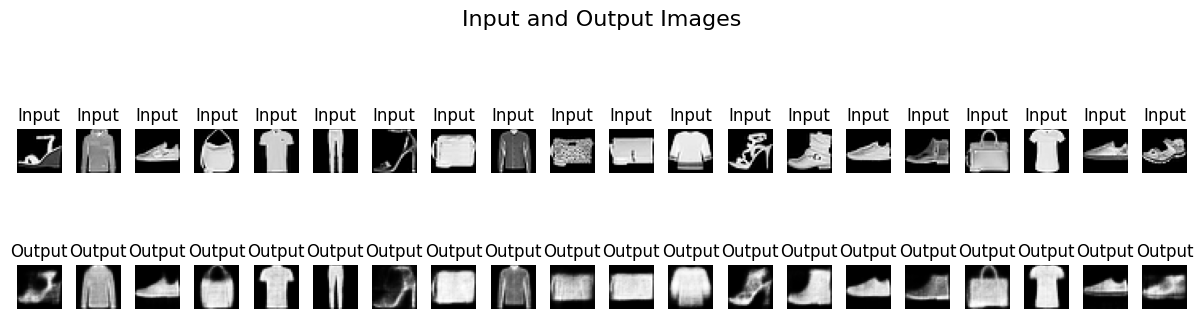

Configuration: num_layers=3, encoding_dim=30
Epoch [1/10], Training Loss: 0.0978, Validation Loss: 0.0658
Configuration: num_layers=3, encoding_dim=30
Epoch [2/10], Training Loss: 0.0603, Validation Loss: 0.0554
Configuration: num_layers=3, encoding_dim=30
Epoch [3/10], Training Loss: 0.0530, Validation Loss: 0.0503
Configuration: num_layers=3, encoding_dim=30
Epoch [4/10], Training Loss: 0.0491, Validation Loss: 0.0482
Configuration: num_layers=3, encoding_dim=30
Epoch [5/10], Training Loss: 0.0467, Validation Loss: 0.0459
Configuration: num_layers=3, encoding_dim=30
Epoch [6/10], Training Loss: 0.0450, Validation Loss: 0.0447
Configuration: num_layers=3, encoding_dim=30
Epoch [7/10], Training Loss: 0.0438, Validation Loss: 0.0438
Configuration: num_layers=3, encoding_dim=30
Epoch [8/10], Training Loss: 0.0428, Validation Loss: 0.0427
Configuration: num_layers=3, encoding_dim=30
Epoch [9/10], Training Loss: 0.0421, Validation Loss: 0.0423
Configuration: num_layers=3, encoding_dim=30
E

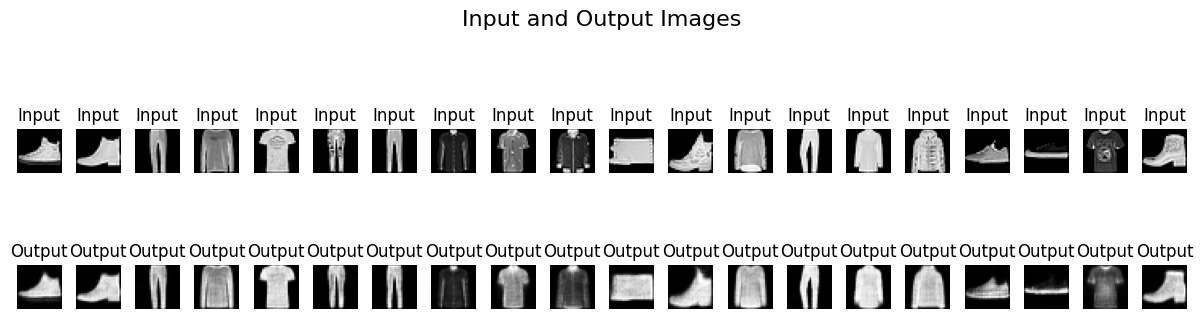

Configuration: num_layers=3, encoding_dim=50
Epoch [1/10], Training Loss: 0.0966, Validation Loss: 0.0644
Configuration: num_layers=3, encoding_dim=50
Epoch [2/10], Training Loss: 0.0591, Validation Loss: 0.0544
Configuration: num_layers=3, encoding_dim=50
Epoch [3/10], Training Loss: 0.0518, Validation Loss: 0.0500
Configuration: num_layers=3, encoding_dim=50
Epoch [4/10], Training Loss: 0.0482, Validation Loss: 0.0466
Configuration: num_layers=3, encoding_dim=50
Epoch [5/10], Training Loss: 0.0459, Validation Loss: 0.0452
Configuration: num_layers=3, encoding_dim=50
Epoch [6/10], Training Loss: 0.0440, Validation Loss: 0.0432
Configuration: num_layers=3, encoding_dim=50
Epoch [7/10], Training Loss: 0.0427, Validation Loss: 0.0419
Configuration: num_layers=3, encoding_dim=50
Epoch [8/10], Training Loss: 0.0418, Validation Loss: 0.0415
Configuration: num_layers=3, encoding_dim=50
Epoch [9/10], Training Loss: 0.0409, Validation Loss: 0.0407
Configuration: num_layers=3, encoding_dim=50
E

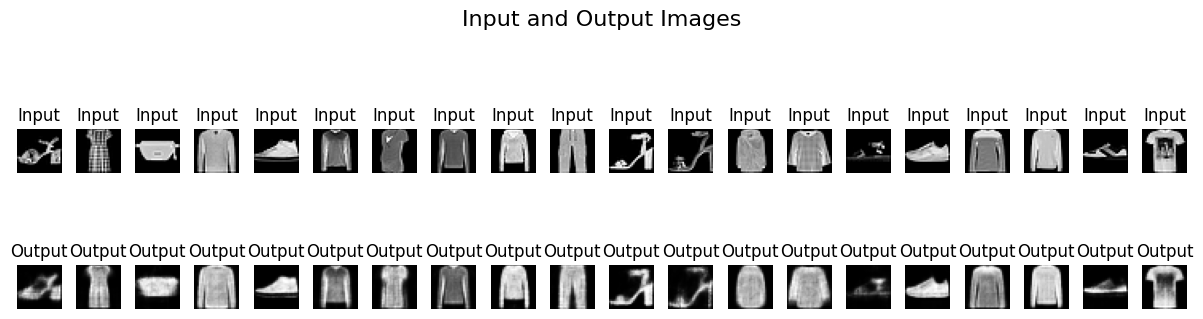

Configuration: num_layers=3, encoding_dim=100
Epoch [1/10], Training Loss: 0.0951, Validation Loss: 0.0634
Configuration: num_layers=3, encoding_dim=100
Epoch [2/10], Training Loss: 0.0587, Validation Loss: 0.0532
Configuration: num_layers=3, encoding_dim=100
Epoch [3/10], Training Loss: 0.0510, Validation Loss: 0.0486
Configuration: num_layers=3, encoding_dim=100
Epoch [4/10], Training Loss: 0.0472, Validation Loss: 0.0453
Configuration: num_layers=3, encoding_dim=100
Epoch [5/10], Training Loss: 0.0449, Validation Loss: 0.0437
Configuration: num_layers=3, encoding_dim=100
Epoch [6/10], Training Loss: 0.0434, Validation Loss: 0.0425
Configuration: num_layers=3, encoding_dim=100
Epoch [7/10], Training Loss: 0.0421, Validation Loss: 0.0409
Configuration: num_layers=3, encoding_dim=100
Epoch [8/10], Training Loss: 0.0412, Validation Loss: 0.0405
Configuration: num_layers=3, encoding_dim=100
Epoch [9/10], Training Loss: 0.0406, Validation Loss: 0.0401
Configuration: num_layers=3, encoding

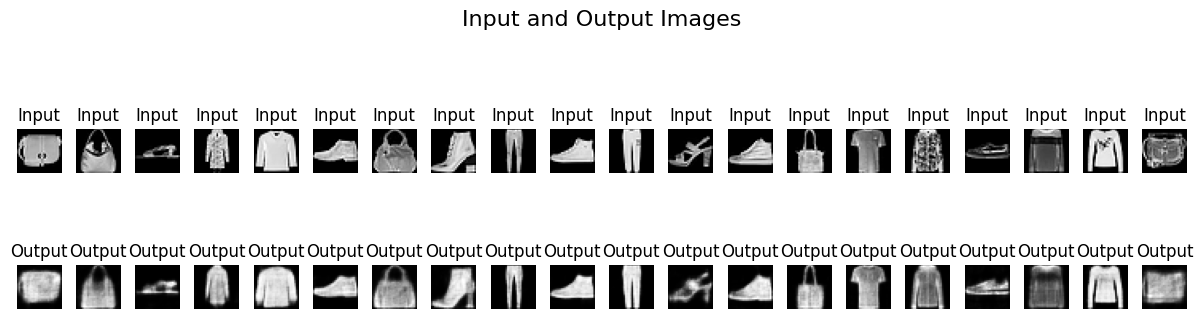

Configuration: num_layers=5, encoding_dim=15
Epoch [1/10], Training Loss: 0.1419, Validation Loss: 0.0966
Configuration: num_layers=5, encoding_dim=15
Epoch [2/10], Training Loss: 0.0891, Validation Loss: 0.0849
Configuration: num_layers=5, encoding_dim=15
Epoch [3/10], Training Loss: 0.0831, Validation Loss: 0.0822
Configuration: num_layers=5, encoding_dim=15
Epoch [4/10], Training Loss: 0.0806, Validation Loss: 0.0797
Configuration: num_layers=5, encoding_dim=15
Epoch [5/10], Training Loss: 0.0788, Validation Loss: 0.0784
Configuration: num_layers=5, encoding_dim=15
Epoch [6/10], Training Loss: 0.0770, Validation Loss: 0.0768
Configuration: num_layers=5, encoding_dim=15
Epoch [7/10], Training Loss: 0.0746, Validation Loss: 0.0740
Configuration: num_layers=5, encoding_dim=15
Epoch [8/10], Training Loss: 0.0717, Validation Loss: 0.0717
Configuration: num_layers=5, encoding_dim=15
Epoch [9/10], Training Loss: 0.0696, Validation Loss: 0.0699
Configuration: num_layers=5, encoding_dim=15
E

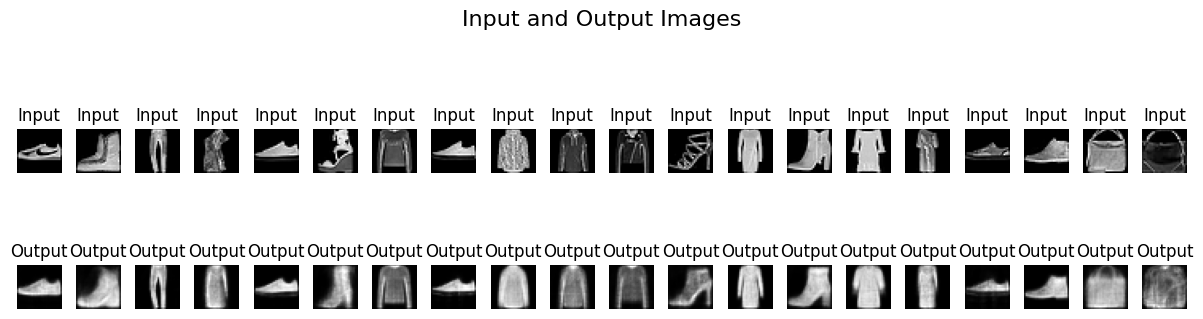

Configuration: num_layers=5, encoding_dim=30
Epoch [1/10], Training Loss: 0.1455, Validation Loss: 0.0981
Configuration: num_layers=5, encoding_dim=30
Epoch [2/10], Training Loss: 0.0911, Validation Loss: 0.0860
Configuration: num_layers=5, encoding_dim=30
Epoch [3/10], Training Loss: 0.0834, Validation Loss: 0.0807
Configuration: num_layers=5, encoding_dim=30
Epoch [4/10], Training Loss: 0.0786, Validation Loss: 0.0763
Configuration: num_layers=5, encoding_dim=30
Epoch [5/10], Training Loss: 0.0744, Validation Loss: 0.0733
Configuration: num_layers=5, encoding_dim=30
Epoch [6/10], Training Loss: 0.0718, Validation Loss: 0.0717
Configuration: num_layers=5, encoding_dim=30
Epoch [7/10], Training Loss: 0.0682, Validation Loss: 0.0667
Configuration: num_layers=5, encoding_dim=30
Epoch [8/10], Training Loss: 0.0656, Validation Loss: 0.0658
Configuration: num_layers=5, encoding_dim=30
Epoch [9/10], Training Loss: 0.0641, Validation Loss: 0.0643
Configuration: num_layers=5, encoding_dim=30
E

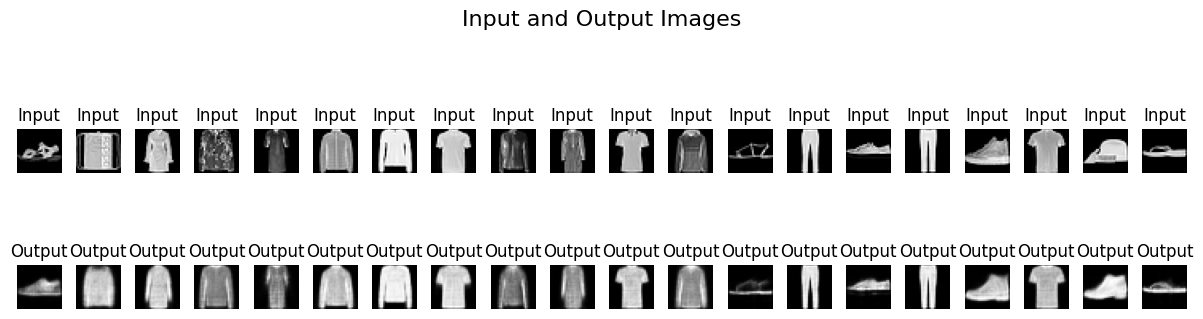

Configuration: num_layers=5, encoding_dim=50
Epoch [1/10], Training Loss: 0.1443, Validation Loss: 0.0978
Configuration: num_layers=5, encoding_dim=50
Epoch [2/10], Training Loss: 0.0890, Validation Loss: 0.0839
Configuration: num_layers=5, encoding_dim=50
Epoch [3/10], Training Loss: 0.0830, Validation Loss: 0.0822
Configuration: num_layers=5, encoding_dim=50
Epoch [4/10], Training Loss: 0.0804, Validation Loss: 0.0793
Configuration: num_layers=5, encoding_dim=50
Epoch [5/10], Training Loss: 0.0779, Validation Loss: 0.0761
Configuration: num_layers=5, encoding_dim=50
Epoch [6/10], Training Loss: 0.0742, Validation Loss: 0.0724
Configuration: num_layers=5, encoding_dim=50
Epoch [7/10], Training Loss: 0.0712, Validation Loss: 0.0702
Configuration: num_layers=5, encoding_dim=50
Epoch [8/10], Training Loss: 0.0694, Validation Loss: 0.0685
Configuration: num_layers=5, encoding_dim=50
Epoch [9/10], Training Loss: 0.0672, Validation Loss: 0.0659
Configuration: num_layers=5, encoding_dim=50
E

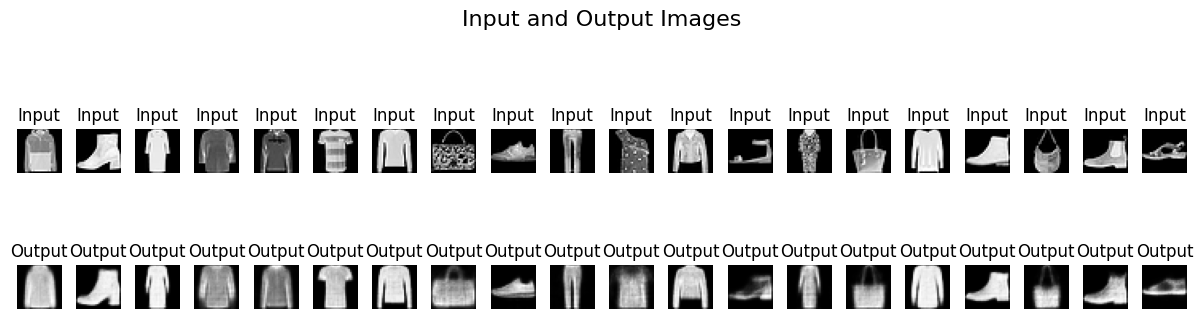

Configuration: num_layers=5, encoding_dim=100
Epoch [1/10], Training Loss: 0.1469, Validation Loss: 0.0991
Configuration: num_layers=5, encoding_dim=100
Epoch [2/10], Training Loss: 0.0917, Validation Loss: 0.0847
Configuration: num_layers=5, encoding_dim=100
Epoch [3/10], Training Loss: 0.0841, Validation Loss: 0.0833
Configuration: num_layers=5, encoding_dim=100
Epoch [4/10], Training Loss: 0.0812, Validation Loss: 0.0798
Configuration: num_layers=5, encoding_dim=100
Epoch [5/10], Training Loss: 0.0786, Validation Loss: 0.0763
Configuration: num_layers=5, encoding_dim=100
Epoch [6/10], Training Loss: 0.0751, Validation Loss: 0.0735
Configuration: num_layers=5, encoding_dim=100
Epoch [7/10], Training Loss: 0.0700, Validation Loss: 0.0681
Configuration: num_layers=5, encoding_dim=100
Epoch [8/10], Training Loss: 0.0668, Validation Loss: 0.0657
Configuration: num_layers=5, encoding_dim=100
Epoch [9/10], Training Loss: 0.0652, Validation Loss: 0.0655
Configuration: num_layers=5, encoding

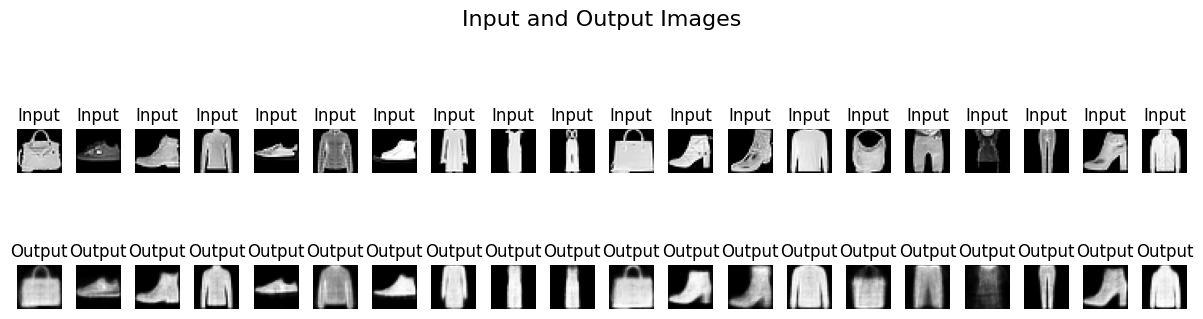

Best Validation Loss: 0.03955049940426834


In [ ]:
best_loss_lasso2, best_model_lasso2, losses_lasso2 = training_lasso(configurations,num_epochs, train_loader2, testset, lasso_lambda, learning_rate)

In [ ]:
print('best_loss_lasso2',best_loss_lasso2)
print('best_model_lasso2', best_model_lasso2)

best_loss_lasso2 0.03955049940426834
best_model_lasso2 Autoencoder_Lasso(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=512, out_features=128, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=128, out_features=50, bias=True)
    (5): Tanh()
  )
  (decoder): Sequential(
    (0): Linear(in_features=50, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=512, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=512, out_features=784, bias=True)
    (5): Tanh()
  )
)


### Plot Comparison Among Different Regularization Techniques

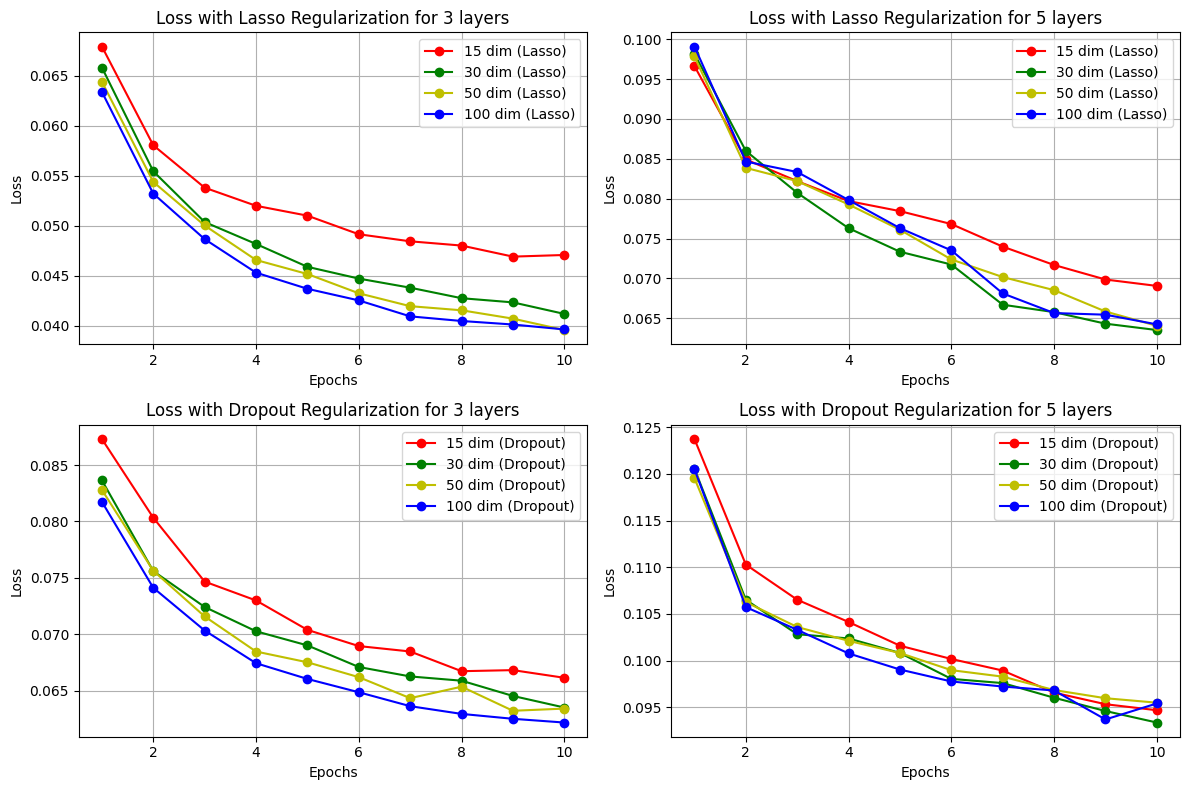

In [ ]:
plot_loss(num_epochs, losses_lasso2, losses_dropout2)

### FMNIST - DENOISING

Training with noise variance: 0.1
Epoch [1/10], Loss: 0.0597, PSNR: 10.6117, Validation PSNR: 11.9274
Epoch [2/10], Loss: 0.0635, PSNR: 12.3533, Validation PSNR: 12.6625
Epoch [3/10], Loss: 0.0549, PSNR: 12.9466, Validation PSNR: 13.1017
Epoch [4/10], Loss: 0.0546, PSNR: 13.2857, Validation PSNR: 13.3951
Epoch [5/10], Loss: 0.0404, PSNR: 13.5113, Validation PSNR: 13.5621
Epoch [6/10], Loss: 0.0340, PSNR: 13.6693, Validation PSNR: 13.6965
Epoch [7/10], Loss: 0.0488, PSNR: 13.7857, Validation PSNR: 13.7747
Epoch [8/10], Loss: 0.0360, PSNR: 13.8768, Validation PSNR: 13.7952
Epoch [9/10], Loss: 0.0454, PSNR: 13.9403, Validation PSNR: 13.8778
Epoch [10/10], Loss: 0.0448, PSNR: 13.9966, Validation PSNR: 13.9404


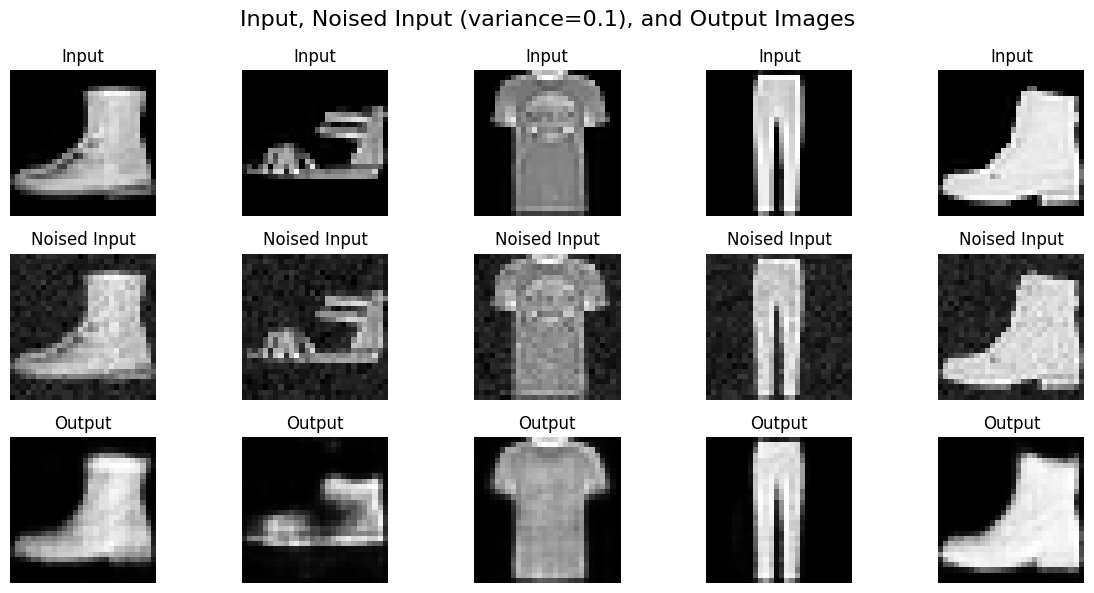

Training with noise variance: 0.25
Epoch [1/10], Loss: 0.0720, PSNR: 10.3759, Validation PSNR: 11.7084
Epoch [2/10], Loss: 0.0691, PSNR: 12.1049, Validation PSNR: 12.4020
Epoch [3/10], Loss: 0.0408, PSNR: 12.6570, Validation PSNR: 12.8382
Epoch [4/10], Loss: 0.0450, PSNR: 12.9446, Validation PSNR: 13.0035
Epoch [5/10], Loss: 0.0543, PSNR: 13.1378, Validation PSNR: 13.1793
Epoch [6/10], Loss: 0.0429, PSNR: 13.2774, Validation PSNR: 13.2283
Epoch [7/10], Loss: 0.0464, PSNR: 13.3877, Validation PSNR: 13.3848
Epoch [8/10], Loss: 0.0533, PSNR: 13.4752, Validation PSNR: 13.3274
Epoch [9/10], Loss: 0.0423, PSNR: 13.5345, Validation PSNR: 13.5000
Epoch [10/10], Loss: 0.0485, PSNR: 13.5802, Validation PSNR: 13.4967


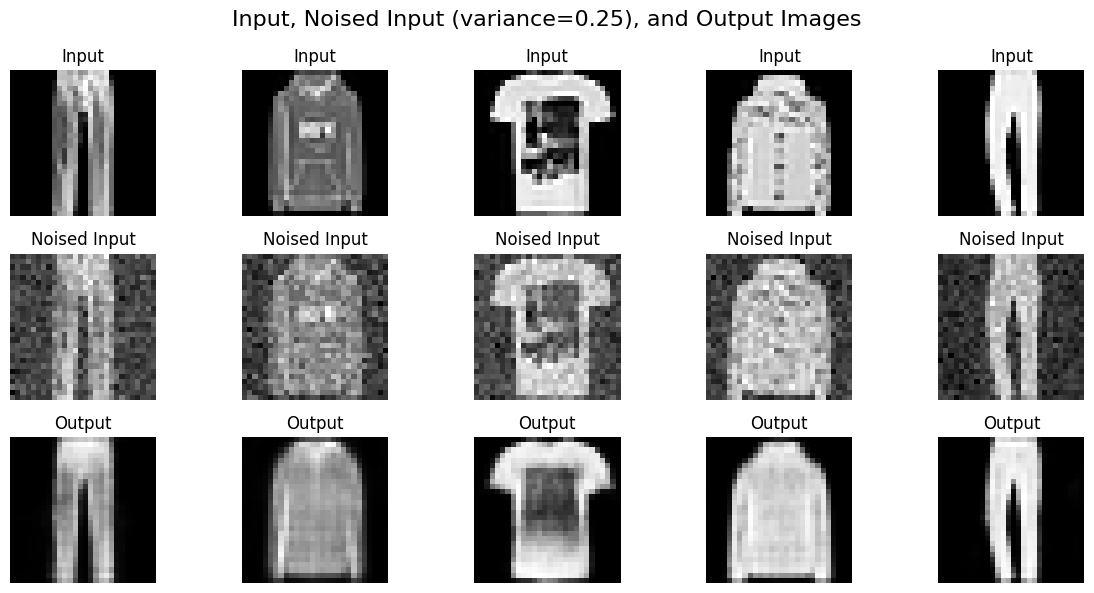

Training with noise variance: 0.5
Epoch [1/10], Loss: 0.0778, PSNR: 10.2412, Validation PSNR: 11.3753
Epoch [2/10], Loss: 0.0579, PSNR: 11.8103, Validation PSNR: 12.0824
Epoch [3/10], Loss: 0.0671, PSNR: 12.2803, Validation PSNR: 12.3218
Epoch [4/10], Loss: 0.0613, PSNR: 12.5216, Validation PSNR: 12.5863
Epoch [5/10], Loss: 0.0474, PSNR: 12.6926, Validation PSNR: 12.7141
Epoch [6/10], Loss: 0.0578, PSNR: 12.8047, Validation PSNR: 12.8041
Epoch [7/10], Loss: 0.0556, PSNR: 12.8983, Validation PSNR: 12.9155
Epoch [8/10], Loss: 0.0472, PSNR: 12.9751, Validation PSNR: 12.9600
Epoch [9/10], Loss: 0.0530, PSNR: 13.0358, Validation PSNR: 13.0078
Epoch [10/10], Loss: 0.0498, PSNR: 13.0813, Validation PSNR: 13.0066


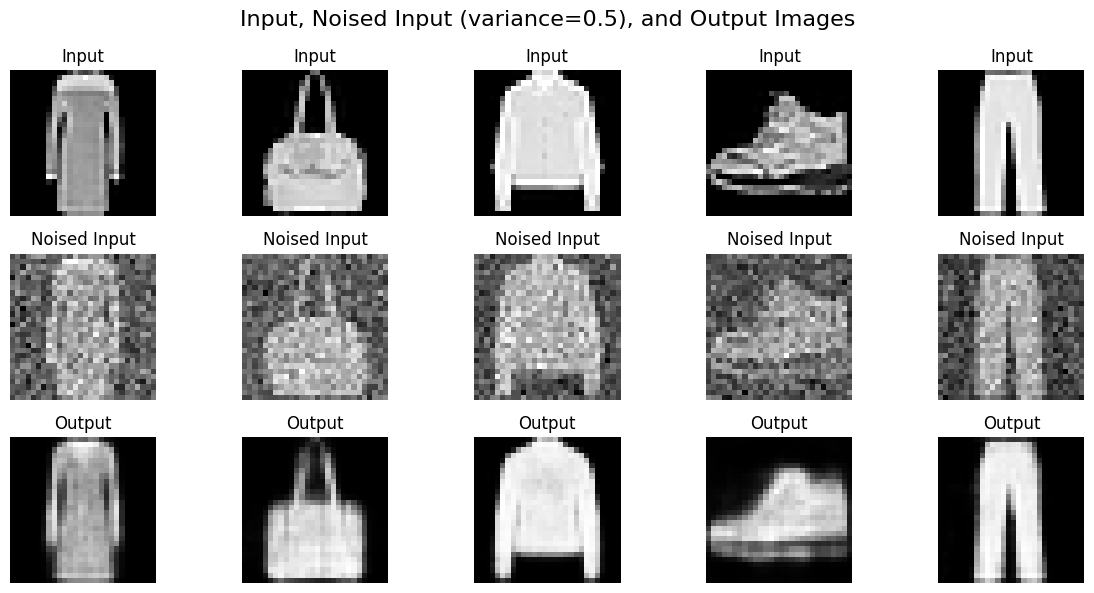

Training with noise variance: 0.75
Epoch [1/10], Loss: 0.0786, PSNR: 10.0314, Validation PSNR: 11.1044
Epoch [2/10], Loss: 0.0727, PSNR: 11.4422, Validation PSNR: 11.6710
Epoch [3/10], Loss: 0.0753, PSNR: 11.8570, Validation PSNR: 11.9788
Epoch [4/10], Loss: 0.0721, PSNR: 12.0701, Validation PSNR: 12.1076
Epoch [5/10], Loss: 0.0592, PSNR: 12.2179, Validation PSNR: 12.2220
Epoch [6/10], Loss: 0.0556, PSNR: 12.3159, Validation PSNR: 12.3461
Epoch [7/10], Loss: 0.0528, PSNR: 12.3990, Validation PSNR: 12.4062
Epoch [8/10], Loss: 0.0500, PSNR: 12.4567, Validation PSNR: 12.4335
Epoch [9/10], Loss: 0.0515, PSNR: 12.5054, Validation PSNR: 12.5098
Epoch [10/10], Loss: 0.0579, PSNR: 12.5459, Validation PSNR: 12.5107


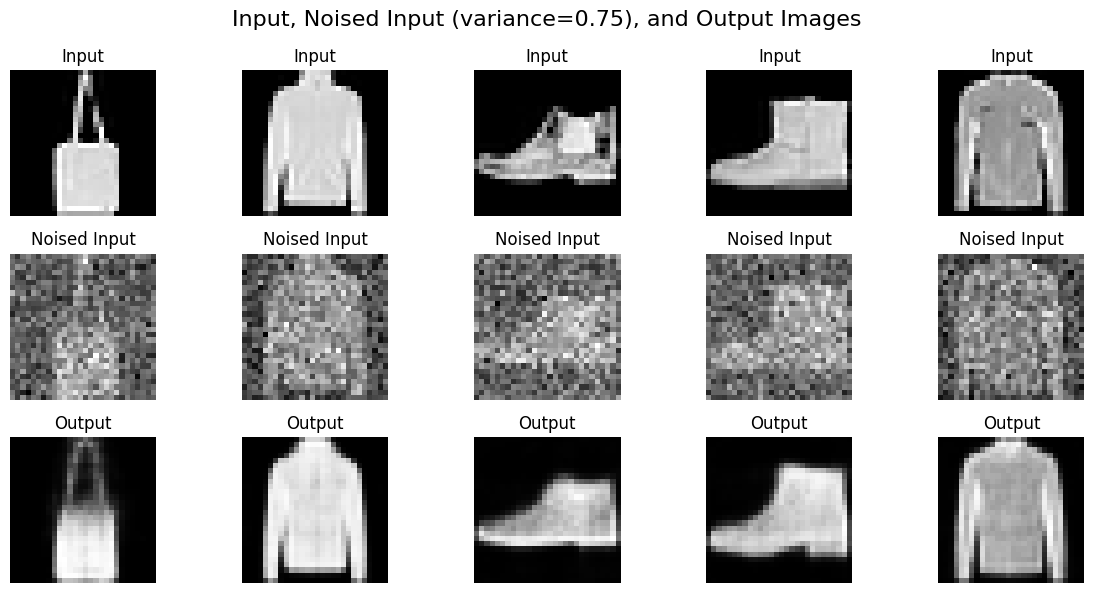

Training with noise variance: 1
Epoch [1/10], Loss: 0.0893, PSNR: 9.8412, Validation PSNR: 10.8400
Epoch [2/10], Loss: 0.0707, PSNR: 11.1022, Validation PSNR: 11.3421
Epoch [3/10], Loss: 0.0791, PSNR: 11.4385, Validation PSNR: 11.5375
Epoch [4/10], Loss: 0.0625, PSNR: 11.6259, Validation PSNR: 11.6958
Epoch [5/10], Loss: 0.0611, PSNR: 11.7467, Validation PSNR: 11.7387
Epoch [6/10], Loss: 0.0708, PSNR: 11.8310, Validation PSNR: 11.8743
Epoch [7/10], Loss: 0.0614, PSNR: 11.9039, Validation PSNR: 11.8960
Epoch [8/10], Loss: 0.0695, PSNR: 11.9475, Validation PSNR: 11.9384
Epoch [9/10], Loss: 0.0583, PSNR: 11.9914, Validation PSNR: 11.9593
Epoch [10/10], Loss: 0.0693, PSNR: 12.0225, Validation PSNR: 12.0151


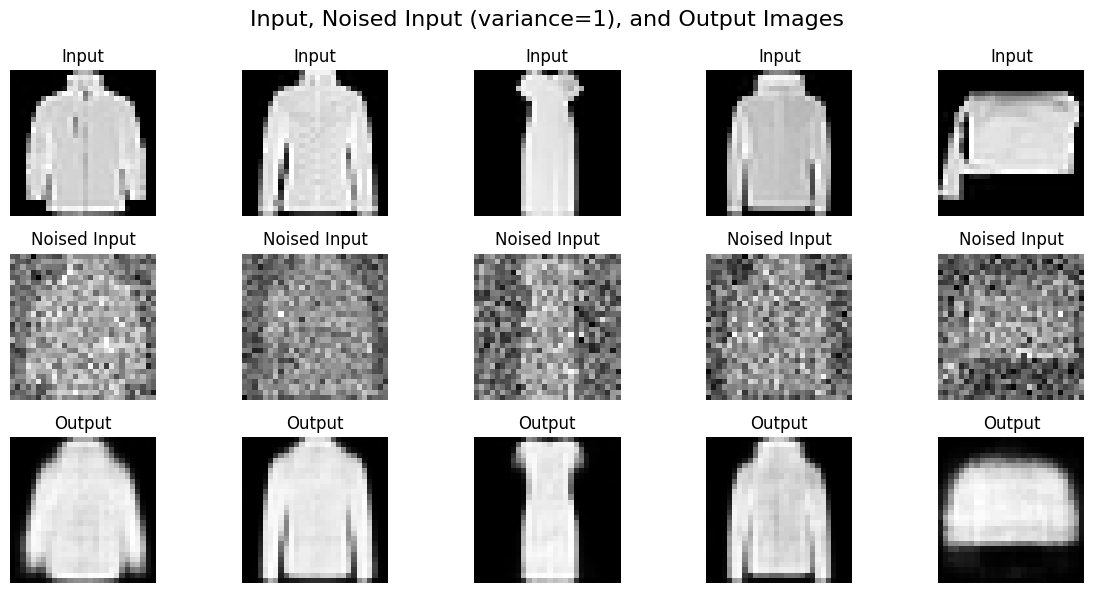

In [ ]:
psnr_dict2 = training_denoising(learning_rate, num_epochs, best_model_lasso2, noise_variances, train_loader2, test_loader2)

### Plot PSNR evolution among different variances

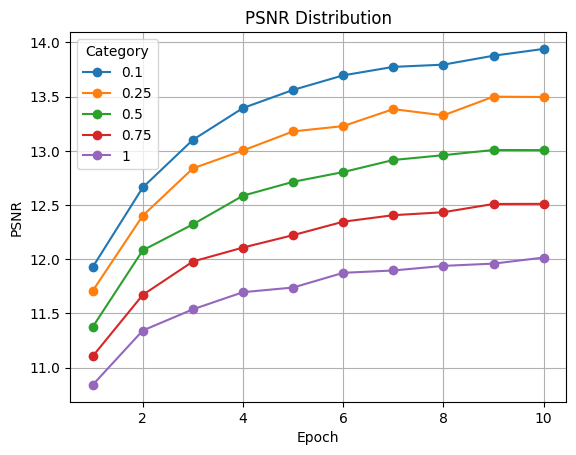

In [ ]:
plot_denoising(psnr_dict2)